In [11]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from wordcloud import WordCloud
import pandas as pd
import nltk
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
import string
import spacy
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
import ast


In [8]:
! pip install textblob
! pip install spacy
! pip install spacy-transformers
! pip install presidio_analyzer
! pip install ast
! pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.1.0/en_core_web_trf-3.1.0.tar.gz
! pip install presidio-analyzer
! python -m spacy download en_core_web_trf
! python -m spacy download en_core_web_lg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/w8/h17mq4cj57xf632w6g0q6lv40000gn/T/pip-install-ja61yxph/ast_08af2f3aec0442f1a3000f7f59df95f6/setup.py", line 6, in <module>
          README = codecs.open(os.path.join(here, 'AST/README'), encoding='utf8').read()
        File "/Users/luyifan/.pyenv/versions/3.10.4/lib/python3.10/codecs.py", line 905, in open
          file = builtins.open(filename, mode, buffering)
      FileNotFoundError: [

In [2]:
df = pd.read_csv('../../Datasets/YelpFakeReview(Tagged DF).csv')
df = df.dropna(subset=['reviewContent'])

In [3]:
df.head(5)

reviewDate                reviewID              reviewerID  \
0  9/22/2012  GtwU21YOQn-wf4vWRUIx6w  bNYesZ944s6IJVowOnB0iA   
1  9/22/2012                 0LpVTc3  TRKxLC3y-ZvP45e5iilMtw   
2  9/19/2012           tljtLzf68Fkwf  0EMm8umAqXZzyhxNpL4M9g   
3   9/6/2012                     iSN  DlwexC7z88ymAzu45skODw   
4   9/9/2012                  Jmwrh7  kW2dk1CWihmh3g7k9N2G8A   

                                       reviewContent  reviewRating  \
0  Unlike Next, which we'd eaten at the previous ...             5   
1  Probably one of the best meals I've had ever. ...             5   
2  Service was impeccable. Experience and present...             3   
3  The problem with places like this, given the e...             3   
4  I have no idea how to write my review - dining...             5   

   reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                  0                0                 0   
1                  0                0                 0   
2                  2                0                 0   
3                  8                0                 3   
4                  1                2                 0   

             restaurantID flagged  ... reviewerUsefulCount reviewerCoolCount  \
0  pbEiXam9YJL3neCYHGwLUA       N  ...                  41                 5   
1  pbEiXam9YJL3neCYHGwLUA       N  ...                   0                 0   
2  pbEiXam9YJL3neCYHGwLUA       N  ...                   6                 0   
3  pbEiXam9YJL3neCYHGwLUA       N  ...                  35                 8   
4  pbEiXam9YJL3neCYHGwLUA       N  ...                1650               679   

  reviewerFunnyCount  reviewerComplimentCount  reviewerTipCount  \
0                  5                        2                 0   
1                  0                        0                 0   
2                  1                        0                 0   
3                  6                        6                11   
4                417                      283                22   

   reviewerFanCount                          resLocation  resName  \
0                 1  Alinea - Lincoln Park - Chicago, IL   Alinea   
1                 0  Alinea - Lincoln Park - Chicago, IL   Alinea   
2                 0  Alinea - Lincoln Park - Chicago, IL   Alinea   
3                 0  Alinea - Lincoln Park - Chicago, IL   Alinea   
4                70  Alinea - Lincoln Park - Chicago, IL   Alinea   

   resReviewCount  resRating  
0             841        4.5  
1             841        4.5  
2             841        4.5  
3             841        4.5  
4             841        4.5  

[5 rows x 26 columns]

### Entity Recognition Extraction from Review using Microsoft Presidio and Spacy model

Presidio Analyzer supports a wide range of entities. Here are some of them that we will be selecting:

- `DATE_TIME`: Absolute or relative dates or periods or times smaller than a day¹.
- `EMAIL_ADDRESS`: An email address identifies an email box to which email messages are delivered¹.
- `NRP`: A person’s Nationality, religious or political group¹.
- `LOCATION`: Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains)¹.
- `PERSON`: A full person name, which can include first names, middle names or initials, and last names¹.
- `PHONE_NUMBER`: A telephone number¹.

In [4]:
# # Initialize the Presidio analyzer engine
analyzer = AnalyzerEngine()

/Users/luyifan/Desktop/BT4012_Reviews/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# # Load the installed model
nlp = spacy.load('en_core_web_trf')

In [6]:
# # Create configuration containing engine name and models
configuration = {
    "nlp_engine_name": "spacy",
    "models": [
        {"lang_code": "en", "model_name": "en_core_web_trf"},
    ],
}

# # Create NLP engine based on configuration
provider = NlpEngineProvider(nlp_configuration=configuration)
nlp_engine = provider.create_engine()

# # Pass the created NLP engine and supported_languages to the AnalyzerEngine
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["en"])

In [7]:
df.reviewContent.isna().sum()

0

In [8]:
# # Assuming df is your DataFrame and 'reviewContent' is your column with text data
entities = ['DATE_TIME', 'EMAIL_ADDRESS', 'NRP', 'LOCATION', 'PERSON', 'PHONE_NUMBER']

for entity in entities:
    df[entity] = None

In [9]:
def analyze_row(row):
    text = row['reviewContent']
    results = analyzer.analyze(text=text, entities=entities, language='en')
    for result in results:
        entity_text = text[result.start : result.end]
        entity_type = result.entity_type
        if row[entity_type] == None:
            row[entity_type] = [entity_text]
        else:
            row[entity_type].append(entity_text)
    return row

In [ ]:
from tqdm import tqdm
tqdm.pandas()
df = df.progress_apply(analyze_row, axis=1)

In [56]:
df.to_csv('Entity_dataframe.csv', index= False)

In [57]:
df = pd.read_csv('Entity_dataframe.csv')

In [58]:
for entity in entities:
    # Convert the string representation of list to actual list
    df[entity] = df[entity].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else np.NaN)
    

In [59]:
for entity in entities:
    # Count of elements in the list in each row
    df[entity + '_count'] = df[entity].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df[entity + '_flag'] = df[entity].apply(lambda x: isinstance(x, list))


In [60]:
df.to_csv('../../Datasets/Entity_Count_Flag_dataframe.csv',index=None)

In [1]:
import pandas as pd
df = pd.read_csv('../../Datasets/Entity_Count_Flag_dataframe.csv')
df

numerical_columns = []
cat_columns = []

for column in df.columns:
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        numerical_columns.append(column)
    else:
        cat_columns.append(column)
print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", cat_columns)

Numerical Columns: ['reviewRating', 'reviewUsefulCount', 'reviewCoolCount', 'reviewFunnyCount', 'reviewerFriendCount', 'reviewerNumReviews', 'reviewerFirstCount', 'reviewerUsefulCount', 'reviewerCoolCount', 'reviewerFunnyCount', 'reviewerComplimentCount', 'reviewerTipCount', 'reviewerFanCount', 'resReviewCount', 'resRating', 'DATE_TIME_count', 'EMAIL_ADDRESS_count', 'NRP_count', 'LOCATION_count', 'PERSON_count', 'PHONE_NUMBER_count']
Categorical Columns: ['reviewDate', 'reviewID', 'reviewerID', 'reviewContent', 'restaurantID', 'flagged', 'reviewerName', 'reviewerLocation', 'reviewerYelpJoinDate', 'resLocation', 'resName', 'DATE_TIME', 'EMAIL_ADDRESS', 'NRP', 'LOCATION', 'PERSON', 'PHONE_NUMBER', 'DATE_TIME_flag', 'EMAIL_ADDRESS_flag', 'NRP_flag', 'LOCATION_flag', 'PERSON_flag', 'PHONE_NUMBER_flag']


C:\Users\fongj\AppData\Local\Temp\ipykernel_22228\3454301683.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Entity_Count_Flag_dataframe.csv')


# Categorical variables

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26956 entries, 0 to 26955
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   reviewDate               26956 non-null  object 
 1   reviewID                 26955 non-null  object 
 2   reviewerID               26956 non-null  object 
 3   reviewContent            26956 non-null  object 
 4   reviewRating             26956 non-null  int64  
 5   reviewUsefulCount        26956 non-null  int64  
 6   reviewCoolCount          26956 non-null  int64  
 7   reviewFunnyCount         26956 non-null  int64  
 8   restaurantID             26956 non-null  object 
 9   flagged                  26956 non-null  object 
 10  reviewerName             26956 non-null  object 
 11  reviewerLocation         26947 non-null  object 
 12  reviewerYelpJoinDate     26956 non-null  object 
 13  reviewerFriendCount      26956 non-null  int64  
 14  reviewerNumReviews    

In [63]:
df.nunique()

reviewDate                  2427
reviewID                   26955
reviewerID                 16675
reviewContent              26938
reviewRating                   5
reviewUsefulCount             32
reviewCoolCount               32
reviewFunnyCount              30
restaurantID                 121
flagged                        2
reviewerName               12931
reviewerLocation            1483
reviewerYelpJoinDate          96
reviewerFriendCount          385
reviewerNumReviews           575
reviewerFirstCount           575
reviewerUsefulCount          765
reviewerCoolCount            600
reviewerFunnyCount           546
reviewerComplimentCount      473
reviewerTipCount             246
reviewerFanCount             115
resLocation                  121
resName                      120
resReviewCount               105
resRating                      4
DATE_TIME                   8769
EMAIL_ADDRESS                  1
NRP                         1480
LOCATION                    2738
PERSON    

In [64]:
df.describe()

reviewRating  reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
count  26956.000000       26956.000000     26956.000000      26956.000000   
mean       3.936192           0.728038         0.452256          0.378765   
std        1.154769           1.853664         1.481294          1.459130   
min        1.000000           0.000000         0.000000          0.000000   
25%        3.000000           0.000000         0.000000          0.000000   
50%        4.000000           0.000000         0.000000          0.000000   
75%        5.000000           1.000000         0.000000          0.000000   
max        5.000000          49.000000        50.000000         52.000000   

       reviewerFriendCount  reviewerNumReviews  reviewerFirstCount  \
count         26956.000000        26956.000000        26956.000000   
mean             47.708043           93.838069           93.838069   
std             220.801472          208.992691          208.992691   
min               0.000000            1.000000            1.000000   
25%               0.000000            6.000000            6.000000   
50%               5.000000           23.000000           23.000000   
75%              27.000000           88.000000           88.000000   
max            4706.000000         2611.000000         2611.000000   

       reviewerUsefulCount  reviewerCoolCount  reviewerFunnyCount  ...  \
count         26956.000000       26956.000000        26956.000000  ...   
mean            207.040399         143.891453          118.208228  ...   
std             969.979165         793.479383          642.400688  ...   
min               0.000000           0.000000            0.000000  ...   
25%               2.000000           1.000000            0.000000  ...   
50%              16.000000           5.000000            5.000000  ...   
75%              85.000000          37.000000           31.000000  ...   
max           21748.000000       19697.000000        17929.000000  ...   

       reviewerTipCount  reviewerFanCount  resReviewCount     resRating  \
count      26956.000000      26956.000000    26956.000000  26956.000000   
mean          10.377801          5.697544      682.513392      3.948657   
std           59.645097         32.160259      313.638374      0.226589   
min            0.000000          0.000000        8.000000      3.500000   
25%            0.000000          0.000000      444.000000      4.000000   
50%            0.000000          0.000000      606.000000      4.000000   
75%            1.000000          2.000000      880.000000      4.000000   
max         2166.000000        640.000000     2122.000000      5.000000   

       DATE_TIME_count  EMAIL_ADDRESS_count     NRP_count  LOCATION_count  \
count     26956.000000         26956.000000  26956.000000    26956.000000   
mean          1.061174             0.000037      0.315885        0.464720   
std           1.588777             0.006091      0.803795        0.948213   
min           0.000000             0.000000      0.000000        0.000000   
25%           0.000000             0.000000      0.000000        0.000000   
50%           0.000000             0.000000      0.000000        0.000000   
75%           2.000000             0.000000      0.000000        1.000000   
max          24.000000             1.000000     15.000000       15.000000   

       PERSON_count  PHONE_NUMBER_count  
count  26956.000000        26956.000000  
mean       0.221027            0.000074  
std        0.728290            0.008613  
min        0.000000            0.000000  
25%        0.000000            0.000000  
50%        0.000000            0.000000  
75%        0.000000            0.000000  
max       19.000000            1.000000  

[8 rows x 21 columns]

In [65]:
df['flagged'] = df['flagged'].replace({"Y": 1, "N": 0})
df['PHONE_NUMBER'] = df['PHONE_NUMBER'].replace({True: 1, False: 0})
df['EMAIL_ADDRESS_count'] = df['EMAIL_ADDRESS_count'].replace({True: 1, False: 0})
df['PHONE_NUMBER_count'] = df['PHONE_NUMBER_count'].replace({True: 1, False: 0})
df['DATE_TIME_flag'] = df['DATE_TIME_flag'].replace({True: 1, False: 0})
df['EMAIL_ADDRESS_flag'] = df['EMAIL_ADDRESS_flag'].replace({True: 1, False: 0})
df['NRP_flag'] = df['NRP_flag'].replace({True: 1, False: 0})
df['LOCATION_flag'] = df['LOCATION_flag'].replace({True: 1, False: 0})
df['PERSON_flag'] = df['PERSON_flag'].replace({True: 1, False: 0})
df['PHONE_NUMBER_flag'] = df['PHONE_NUMBER_flag'].replace({True: 1, False: 0})
df.head()

reviewDate                reviewID              reviewerID  \
0  9/22/2012  GtwU21YOQn-wf4vWRUIx6w  bNYesZ944s6IJVowOnB0iA   
1  9/22/2012                 0LpVTc3  TRKxLC3y-ZvP45e5iilMtw   
2  9/19/2012           tljtLzf68Fkwf  0EMm8umAqXZzyhxNpL4M9g   
3   9/6/2012                     iSN  DlwexC7z88ymAzu45skODw   
4   9/9/2012                  Jmwrh7  kW2dk1CWihmh3g7k9N2G8A   

                                       reviewContent  reviewRating  \
0  Unlike Next, which we'd eaten at the previous ...             5   
1  Probably one of the best meals I've had ever. ...             5   
2  Service was impeccable. Experience and present...             3   
3  The problem with places like this, given the e...             3   
4  I have no idea how to write my review - dining...             5   

   reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                  0                0                 0   
1                  0                0                 0   
2                  2                0                 0   
3                  8                0                 3   
4                  1                2                 0   

             restaurantID  flagged  ... NRP_count LOCATION_count PERSON_count  \
0  pbEiXam9YJL3neCYHGwLUA        0  ...         1              0            4   
1  pbEiXam9YJL3neCYHGwLUA        0  ...         0              0            1   
2  pbEiXam9YJL3neCYHGwLUA        0  ...         0              0            0   
3  pbEiXam9YJL3neCYHGwLUA        0  ...         0              0            2   
4  pbEiXam9YJL3neCYHGwLUA        0  ...         1              1            0   

   PHONE_NUMBER_count  DATE_TIME_flag  EMAIL_ADDRESS_flag  NRP_flag  \
0                   0               1                   0         1   
1                   0               1                   0         0   
2                   0               0                   0         0   
3                   0               1                   0         0   
4                   0               1                   0         1   

   LOCATION_flag  PERSON_flag  PHONE_NUMBER_flag  
0              0            1                  0  
1              0            1                  0  
2              0            0                  0  
3              0            1                  0  
4              1            0                  0  

[5 rows x 44 columns]

In [66]:
missing_values = df.isnull().sum()

print('Columns with missing values:')
print(missing_values[missing_values > 0])

Columns with missing values:
reviewID                1
reviewerLocation        9
DATE_TIME           13641
EMAIL_ADDRESS       26955
NRP                 21593
LOCATION            19120
PERSON              23195
PHONE_NUMBER        26954
dtype: int64


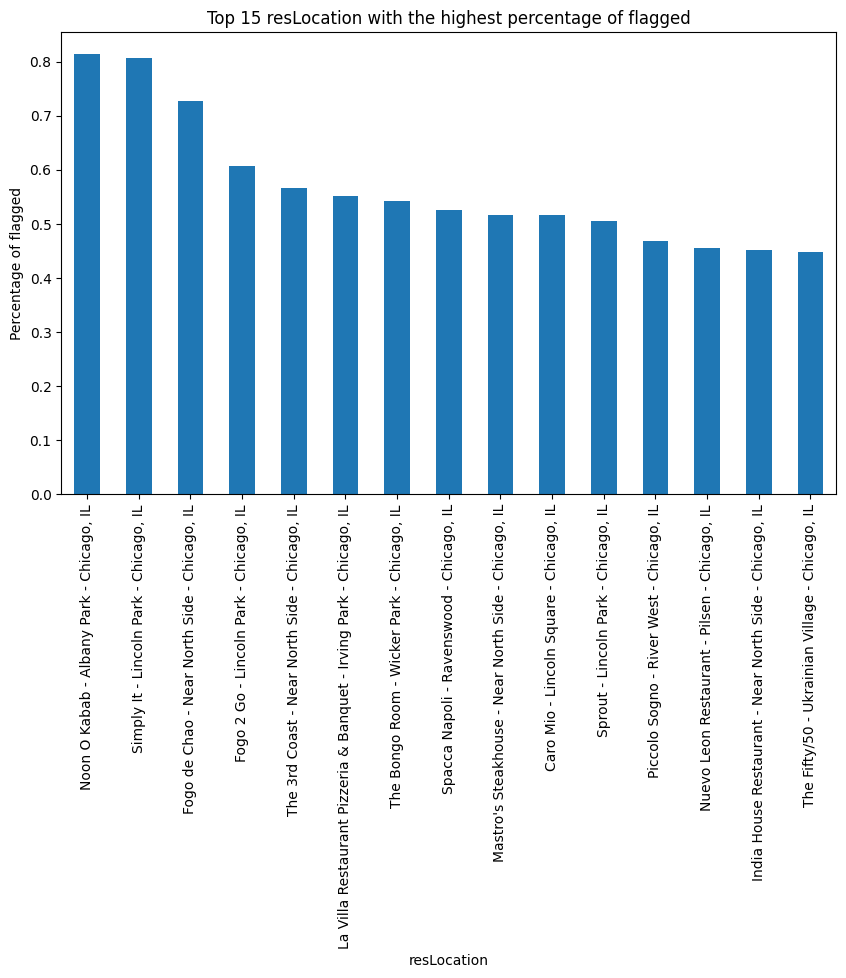

In [67]:
grouped = df.groupby('resLocation')['flagged'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
grouped.plot(kind='bar')
plt.ylabel('Percentage of flagged')
plt.title('Top 15 resLocation with the highest percentage of flagged')
plt.show()

In [68]:
df['reviewerYelpJoinDate'] = pd.to_datetime(df['reviewerYelpJoinDate'], format='mixed')
df['reviewDate2'] = pd.to_datetime(df['reviewDate'], format='mixed')

df['date_diff_joinedandreviewed'] = (df['reviewDate2'] - df['reviewerYelpJoinDate']).dt.days


In [69]:
df.head(5)


reviewDate                reviewID              reviewerID  \
0  9/22/2012  GtwU21YOQn-wf4vWRUIx6w  bNYesZ944s6IJVowOnB0iA   
1  9/22/2012                 0LpVTc3  TRKxLC3y-ZvP45e5iilMtw   
2  9/19/2012           tljtLzf68Fkwf  0EMm8umAqXZzyhxNpL4M9g   
3   9/6/2012                     iSN  DlwexC7z88ymAzu45skODw   
4   9/9/2012                  Jmwrh7  kW2dk1CWihmh3g7k9N2G8A   

                                       reviewContent  reviewRating  \
0  Unlike Next, which we'd eaten at the previous ...             5   
1  Probably one of the best meals I've had ever. ...             5   
2  Service was impeccable. Experience and present...             3   
3  The problem with places like this, given the e...             3   
4  I have no idea how to write my review - dining...             5   

   reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                  0                0                 0   
1                  0                0                 0   
2                  2                0                 0   
3                  8                0                 3   
4                  1                2                 0   

             restaurantID  flagged  ... PERSON_count PHONE_NUMBER_count  \
0  pbEiXam9YJL3neCYHGwLUA        0  ...            4                  0   
1  pbEiXam9YJL3neCYHGwLUA        0  ...            1                  0   
2  pbEiXam9YJL3neCYHGwLUA        0  ...            0                  0   
3  pbEiXam9YJL3neCYHGwLUA        0  ...            2                  0   
4  pbEiXam9YJL3neCYHGwLUA        0  ...            0                  0   

  DATE_TIME_flag  EMAIL_ADDRESS_flag  NRP_flag  LOCATION_flag  PERSON_flag  \
0              1                   0         1              0            1   
1              1                   0         0              0            1   
2              0                   0         0              0            0   
3              1                   0         0              0            1   
4              1                   0         1              1            0   

   PHONE_NUMBER_flag  reviewDate2  date_diff_joinedandreviewed  
0                  0   2012-09-22                         1087  
1                  0   2012-09-22                          479  
2                  0   2012-09-19                         1479  
3                  0   2012-09-06                         1802  
4                  0   2012-09-09                         1897  

[5 rows x 46 columns]

/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/628546070.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df["flagged"]==1][column], fill=True, color="red", label="Fraud", ax=ax)
/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/628546070.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df["flagged"]==1][column], fill=True, color="red", label="Fraud", ax=ax)
/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/628546070.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df["flagged"]==1][column], fill=True, color="red", label="Fraud", ax=ax)
/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/628546070.py:11: UserWarning: Dataset has 0 variance; skipping density esti

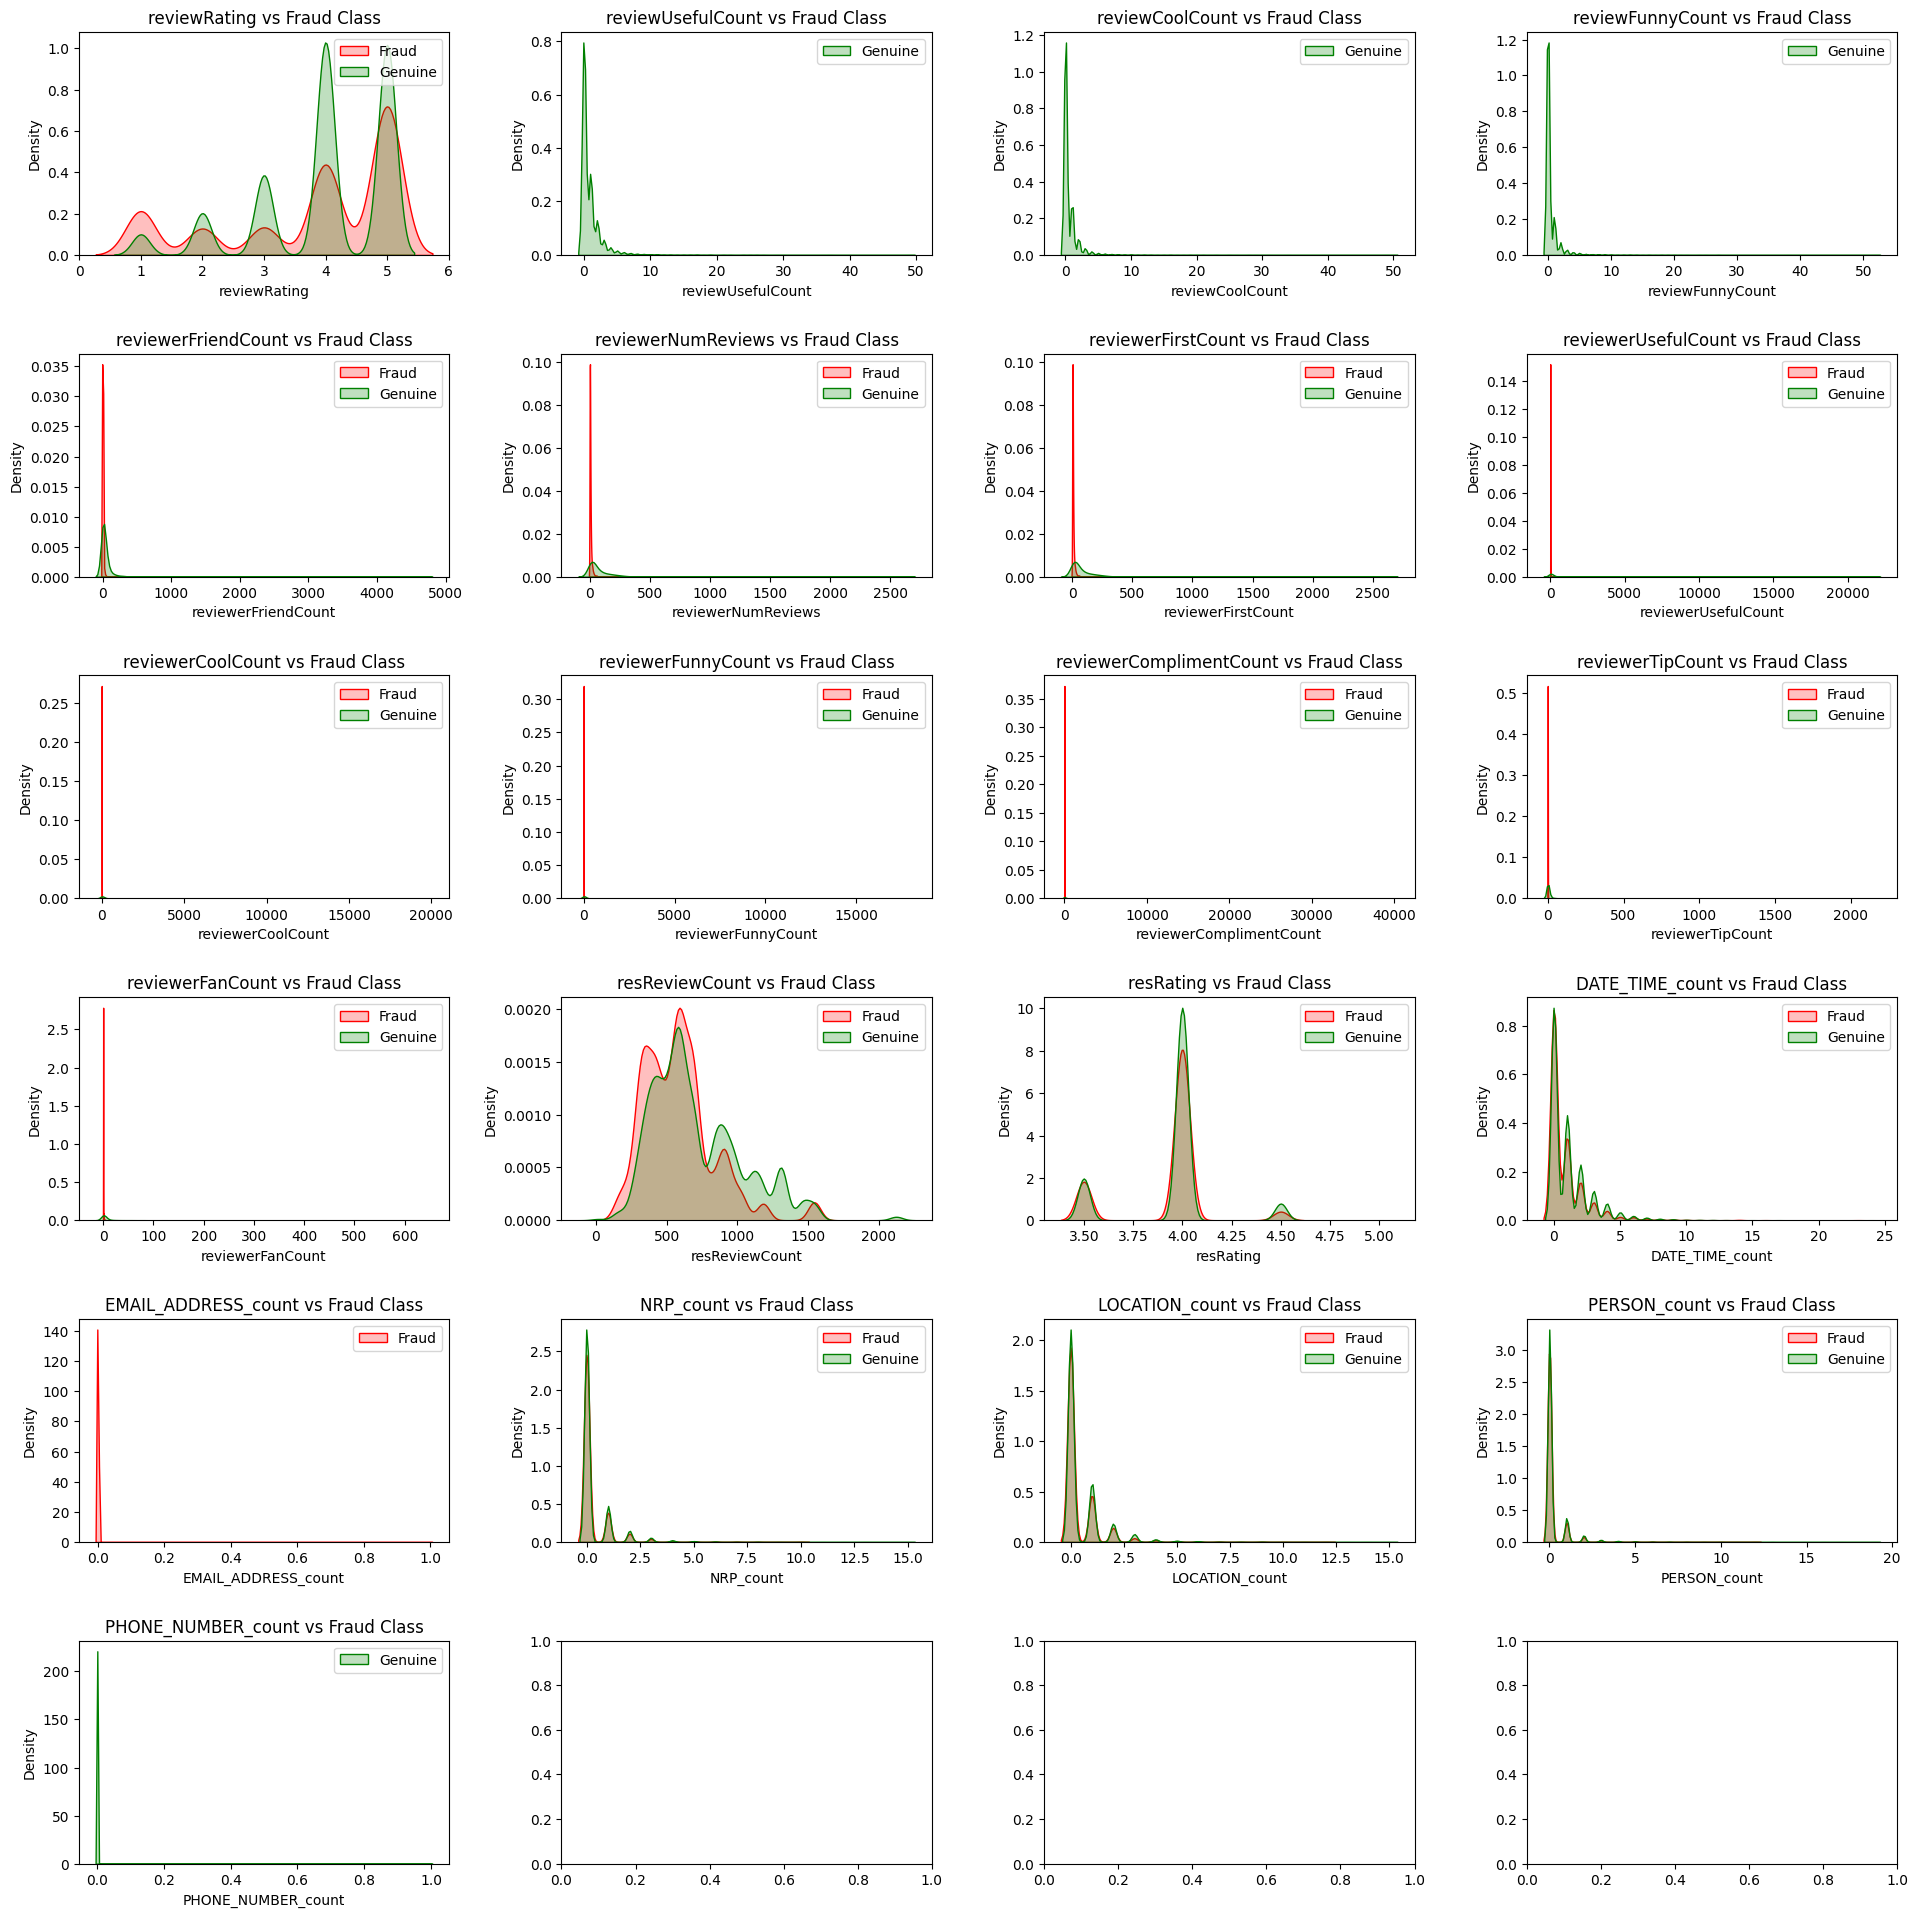

In [70]:
n_rows = 6
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.tight_layout(pad=5)

for ax, column in zip(axes.ravel(), numerical_columns):
    sns.kdeplot(df[df["flagged"]==1][column], fill=True, color="red", label="Fraud", ax=ax)
    sns.kdeplot(df[df["flagged"]==0][column], fill=True, color="green", label="Genuine", ax=ax)
    ax.set_title(column + " vs Fraud Class")
    ax.set_ylabel("Density")
    ax.legend()

plt.show()

### Density Plot Function 

In [71]:
def density_plot(real, flagged, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    sns.kdeplot(real, fill=True, color="green", label="Genuine", ax=ax)
    
    sns.kdeplot(flagged, fill=True, color="red", label="Fraudulent", ax=ax)
    plt.xlim(left = 0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.suptitle(title)

/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/3261830140.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["flagged"]==1]["date_diff_joinedandreviewed"], shade=True, color="red", label="Fake", ax=ax)
/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/3261830140.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["flagged"]==0]["date_diff_joinedandreviewed"], shade=True, color="green", label="Real", ax=ax)


Text(0.5, 0.98, 'Time Difference vs Fraud Class')

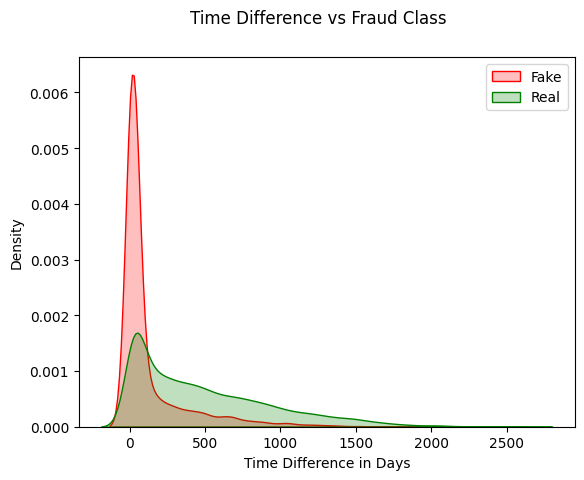

In [72]:
fig, ax = plt.subplots()

sns.kdeplot(df[df["flagged"]==1]["date_diff_joinedandreviewed"], shade=True, color="red", label="Fake", ax=ax)
sns.kdeplot(df[df["flagged"]==0]["date_diff_joinedandreviewed"], shade=True, color="green", label="Real", ax=ax)

ax.set_xlabel("Time Difference in Days")
ax.set_ylabel("Density")
plt.legend() 

fig.suptitle("Time Difference vs Fraud Class")

Text(0.5, 0.98, 'Num of Reviews vs Fraud Class')

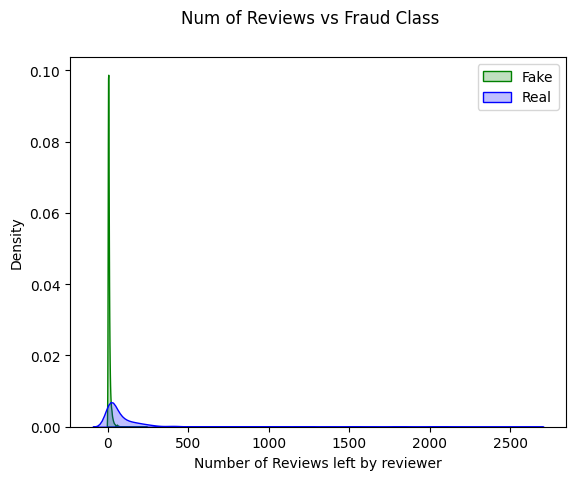

In [73]:
fig, ax = plt.subplots()

sns.kdeplot(df[df["flagged"]==1]["reviewerNumReviews"], fill=True, color="green", label="Fake", ax=ax)
sns.kdeplot(df[df["flagged"]==0]["reviewerNumReviews"], fill=True, color="blue", label="Real", ax=ax)

ax.set_xlabel("Number of Reviews left by reviewer")
ax.set_ylabel("Density")
plt.legend() 

fig.suptitle("Num of Reviews vs Fraud Class")

/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/876658666.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["flagged"]==1]["resReviewCount"], shade=True, color="green", label="Fake", ax=ax)
/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/876658666.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["flagged"]==0]["resReviewCount"], shade=True, color="blue", label="Real", ax=ax)


Text(0.5, 0.98, 'Num of Reviews for restaurant vs Fraud Class')

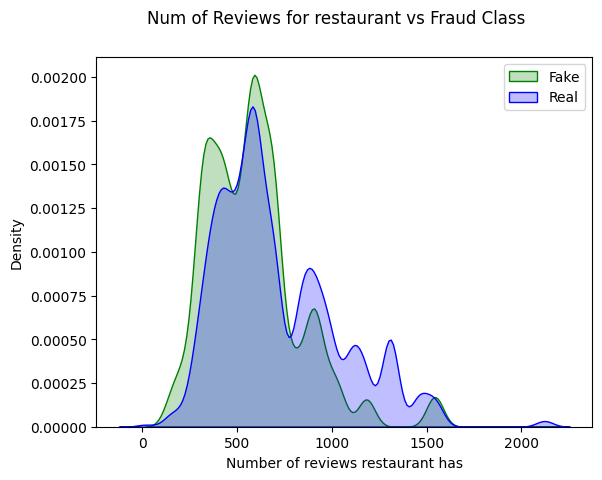

In [74]:
fig, ax = plt.subplots()

sns.kdeplot(df[df["flagged"]==1]["resReviewCount"], shade=True, color="green", label="Fake", ax=ax)
sns.kdeplot(df[df["flagged"]==0]["resReviewCount"], shade=True, color="blue", label="Real", ax=ax)

ax.set_xlabel("Number of reviews restaurant has")
ax.set_ylabel("Density")
plt.legend() 

fig.suptitle("Num of Reviews for restaurant vs Fraud Class")

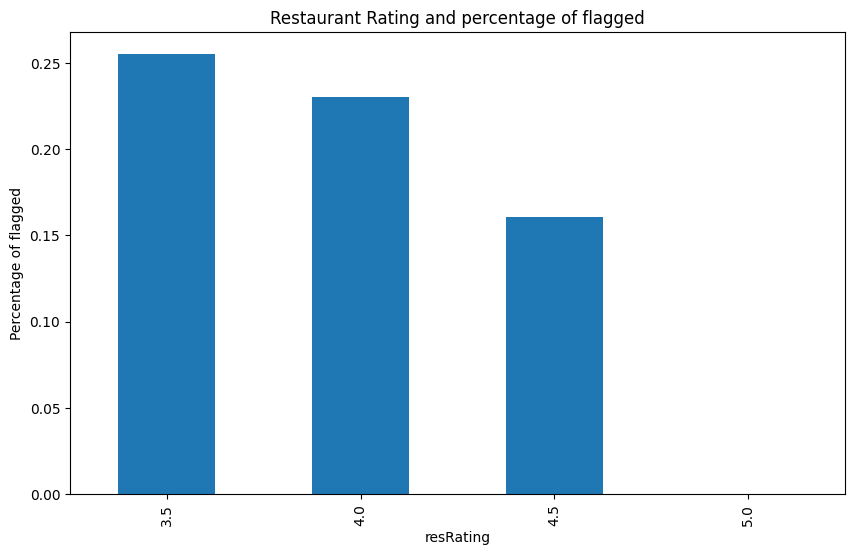

In [75]:
grouped = df.groupby('resRating')['flagged'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
grouped.plot(kind='bar')
plt.ylabel('Percentage of flagged')
plt.title('Restaurant Rating and percentage of flagged')
plt.show()

# Continuous variables

In [76]:
# select numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_df_col = ['reviewerID', 'reviewDate', 'flagged', 'restaurantID', 'reviewRating', 'reviewUsefulCount', 'reviewCoolCount',
       'reviewFunnyCount', 'reviewerFriendCount', 'reviewerNumReviews',
       'reviewerFirstCount', 'reviewerUsefulCount', 'reviewerCoolCount',
       'reviewerFunnyCount', 'reviewerComplimentCount', 'reviewerTipCount',
       'reviewerFanCount', 'resReviewCount', 'resRating', 'DATE_TIME_count',
       'EMAIL_ADDRESS_count', 'NRP_count', 'LOCATION_count', 'PERSON_count',
       'PHONE_NUMBER_count']

# num_df = df[['reviewerID', 'reviewDate', 'reviewRating', 'reviewUsefulCount', 'reviewCoolCount', 'reviewFunnyCount', 'flagged', 'restaurantID']]
num_df = df[num_df_col]
num_df

reviewerID  reviewDate  flagged            restaurantID  \
0      bNYesZ944s6IJVowOnB0iA   9/22/2012        0  pbEiXam9YJL3neCYHGwLUA   
1      TRKxLC3y-ZvP45e5iilMtw   9/22/2012        0  pbEiXam9YJL3neCYHGwLUA   
2      0EMm8umAqXZzyhxNpL4M9g   9/19/2012        0  pbEiXam9YJL3neCYHGwLUA   
3      DlwexC7z88ymAzu45skODw    9/6/2012        0  pbEiXam9YJL3neCYHGwLUA   
4      kW2dk1CWihmh3g7k9N2G8A    9/9/2012        0  pbEiXam9YJL3neCYHGwLUA   
...                       ...         ...      ...                     ...   
26951  tivh8lr6pzBDNfrJLYWh_g   3/17/2010        0  v9qEDxi3t-P0CmGWAkkGvw   
26952  jKs4FQgkV0wSX8BG2_dgTg   4/14/2011        0  RRflazDtBkqqpvEz2hbV2w   
26953  vX6aOMQ3HWCbwZVfCkCauw   9/23/2007        0  zI0E_yruu58ea-xq9aHi-w   
26954  vX6aOMQ3HWCbwZVfCkCauw  11/18/2011        0  6XVXM78gBuU3gpq2hTOgJA   
26955  OZTkqoi8_luhrL-mMj7O8A   5/18/2012        0  Lr4tZOsttQT-BgFtUkUTaQ   

       reviewRating  reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                 5                  0                0                 0   
1                 5                  0                0                 0   
2                 3                  2                0                 0   
3                 3                  8                0                 3   
4                 5                  1                2                 0   
...             ...                ...              ...               ...   
26951             4                  0                0                 1   
26952             5                  0                0                 0   
26953             3                  0                1                 0   
26954             3                  0                0                 0   
26955             4                  0                0                 1   

       reviewerFriendCount  reviewerNumReviews  ...  reviewerTipCount  \
0                       11                  48  ...                 0   
1                        0                   4  ...                 0   
2                        2                  11  ...                 0   
3                       84                  60  ...                11   
4                      333                1209  ...                22   
...                    ...                 ...  ...               ...   
26951                   31                 165  ...                 0   
26952                    6                  11  ...                 0   
26953                   13                  49  ...                 1   
26954                   13                  49  ...                 1   
26955                   13                  14  ...                14   

       reviewerFanCount  resReviewCount  resRating  DATE_TIME_count  \
0                     1             841        4.5                3   
1                     0             841        4.5                2   
2                     0             841        4.5                0   
3                     0             841        4.5                1   
4                    70             841        4.5                1   
...                 ...             ...        ...              ...   
26951                 3              14        4.0                0   
26952                 1              15        4.0                2   
26953                 1              16        4.0                0   
26954                 1              17        4.0                0   
26955                 0              12        4.5                0   

       EMAIL_ADDRESS_count  NRP_count  LOCATION_count  PERSON_count  \
0                        0          1               0             4   
1                        0          0               0             1   
2                        0          0               0             0   
3                        0          0               0             2   
4                        0          1               1             0   
.

In [77]:
#general count of variables

rating_count = num_df['reviewRating'].value_counts().sort_index()
useful_count = num_df['reviewUsefulCount'].value_counts().sort_index()[:10]
cool_count = num_df['reviewCoolCount'].value_counts().sort_index()[:10]
funny_count = num_df['reviewFunnyCount'].value_counts().sort_index()[:10]
flagged_count = num_df['flagged'].value_counts().sort_index()

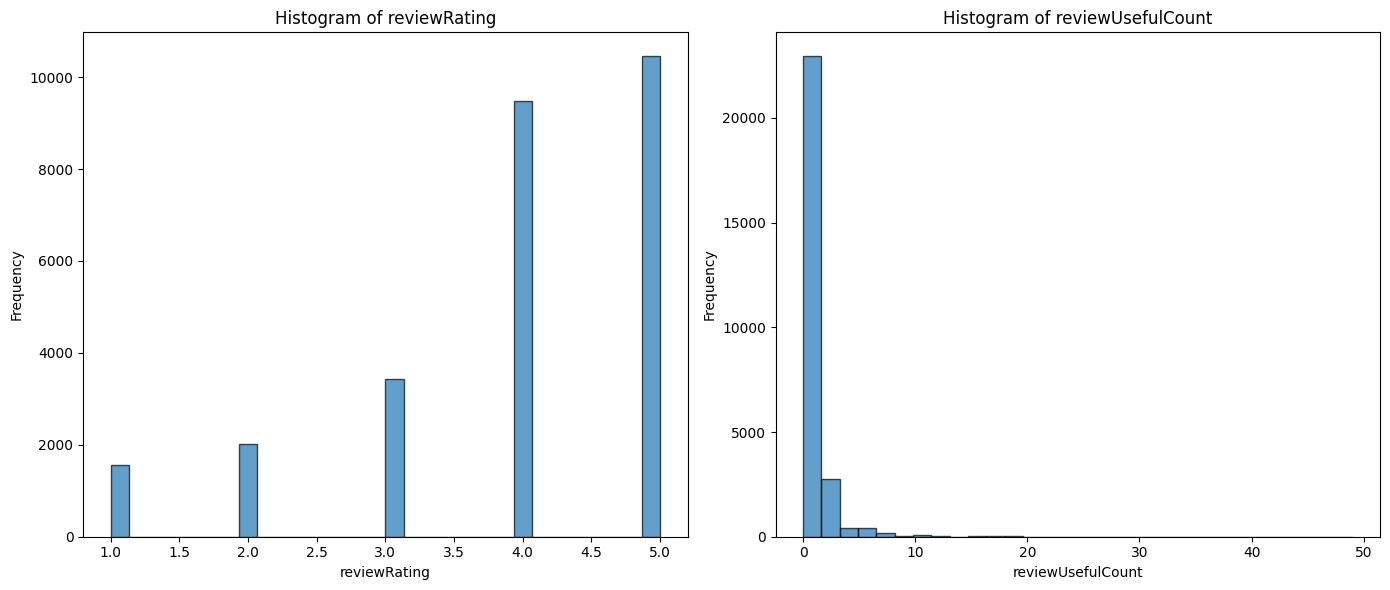

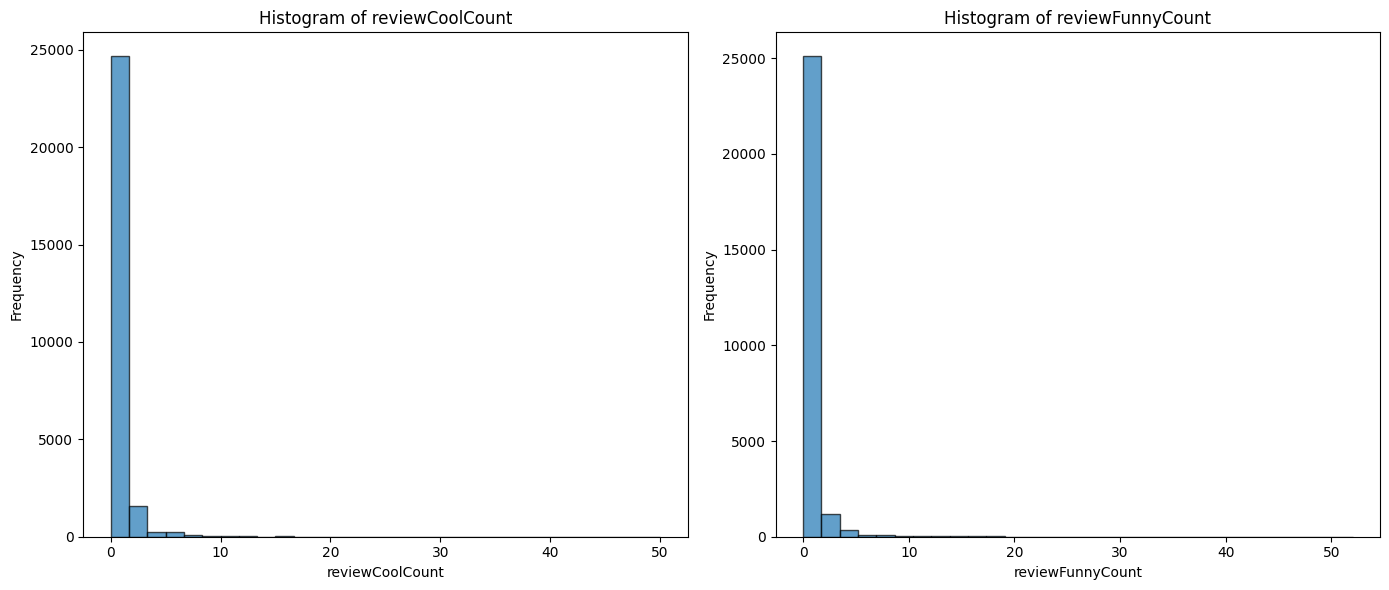

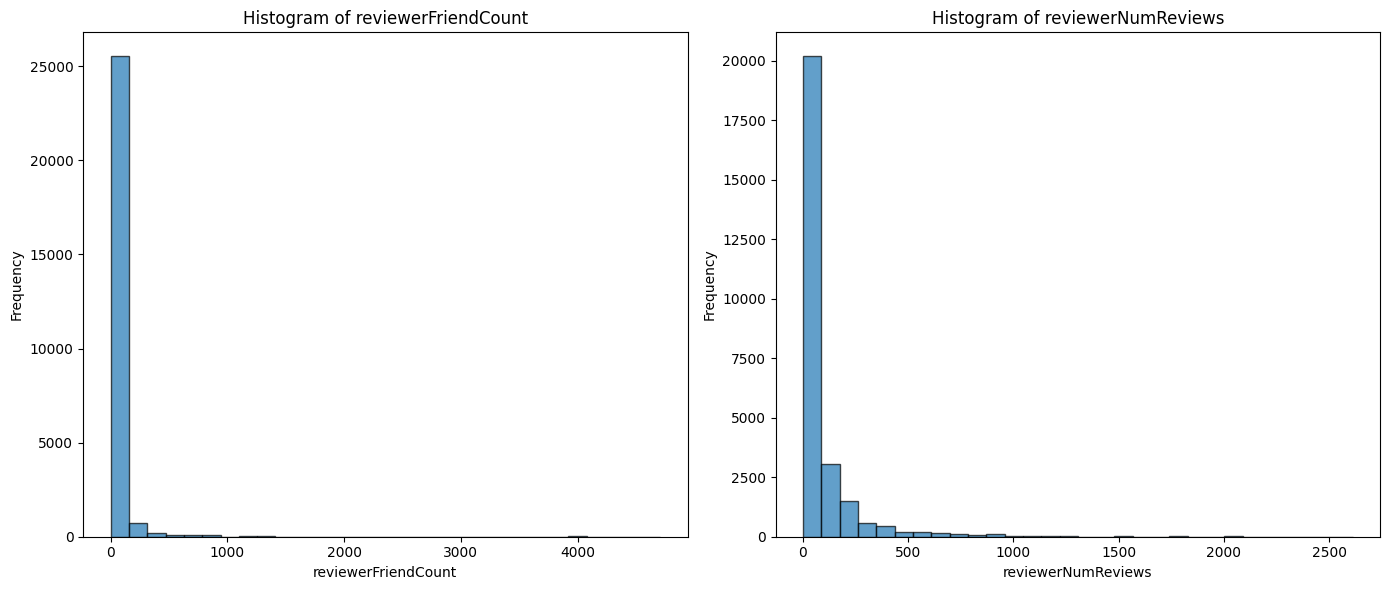

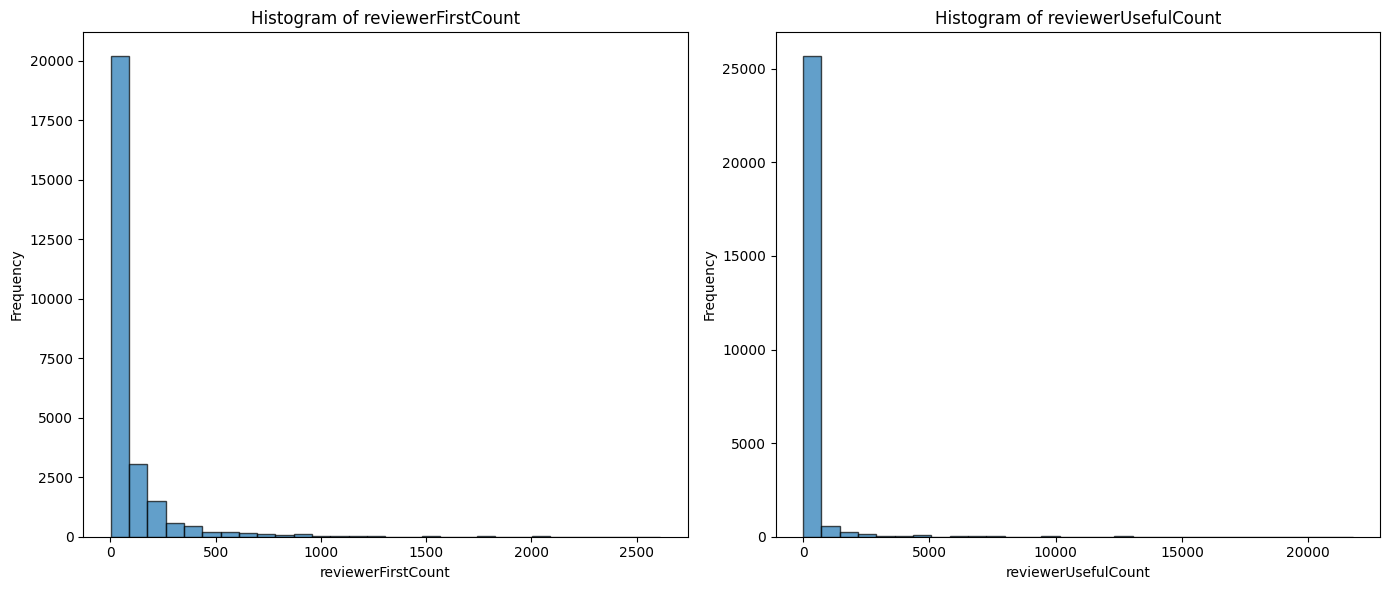

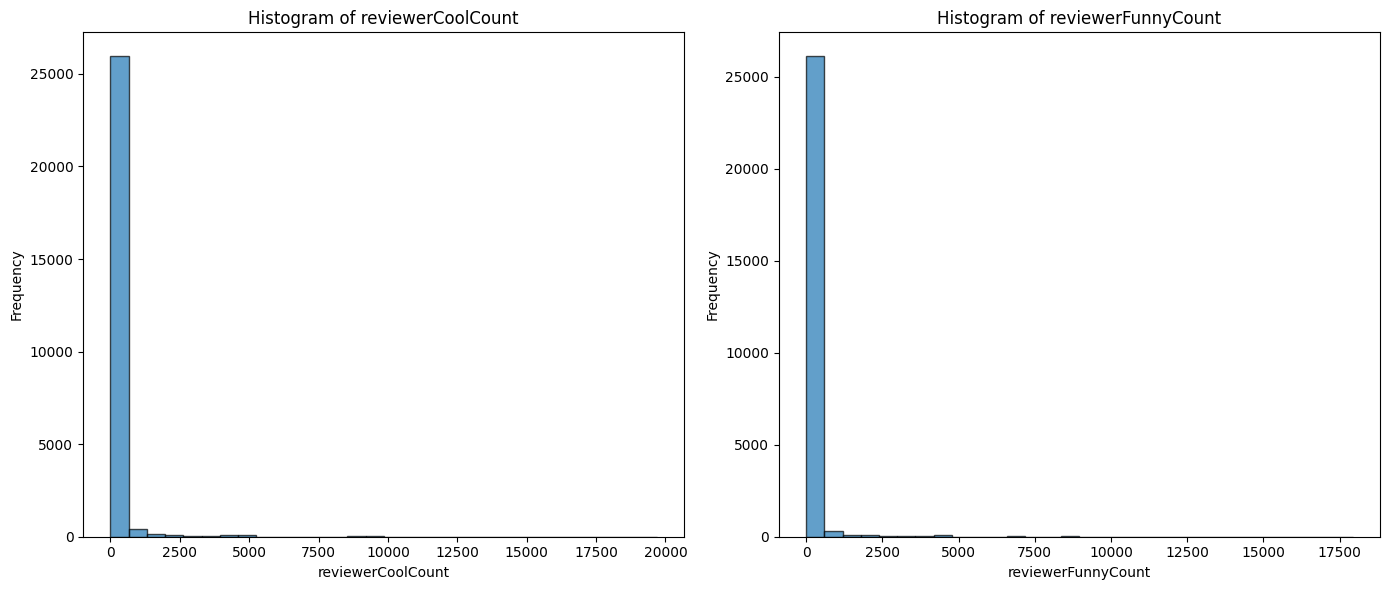

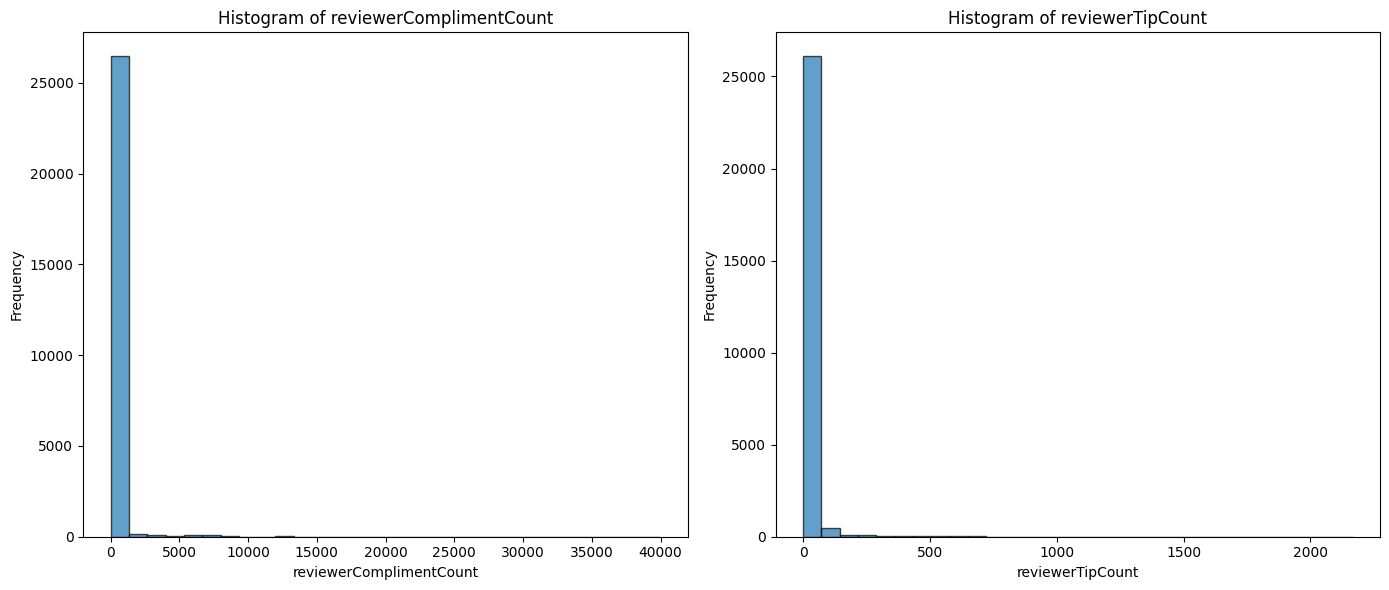

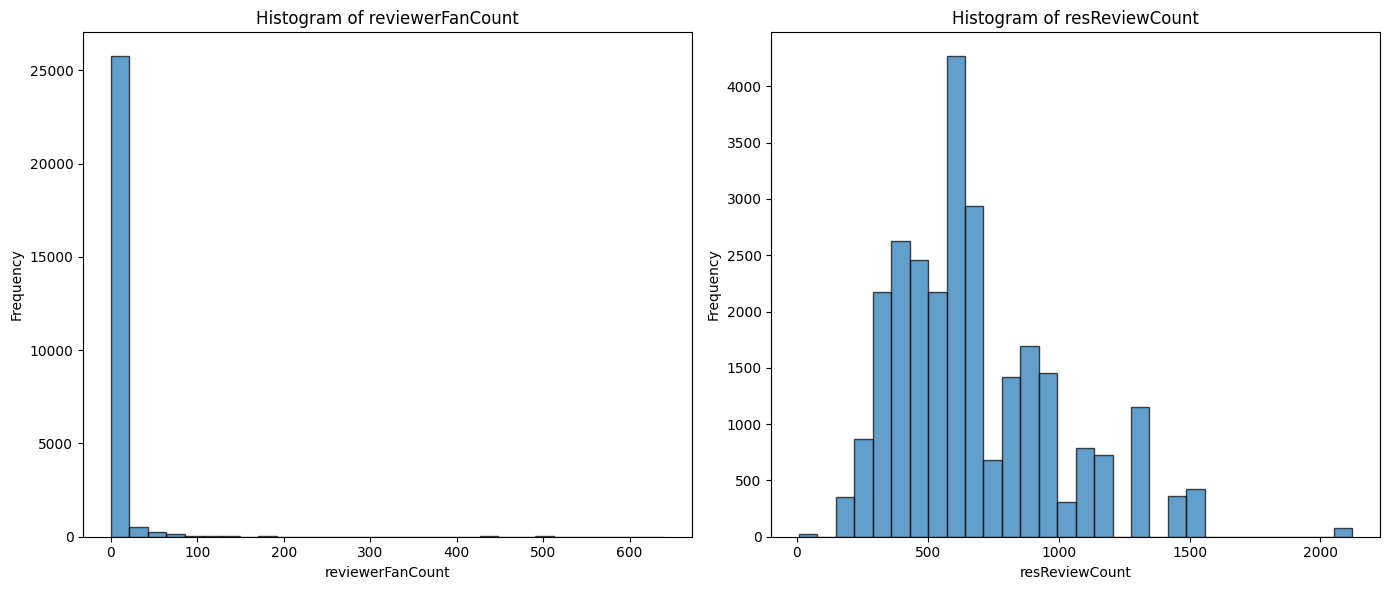

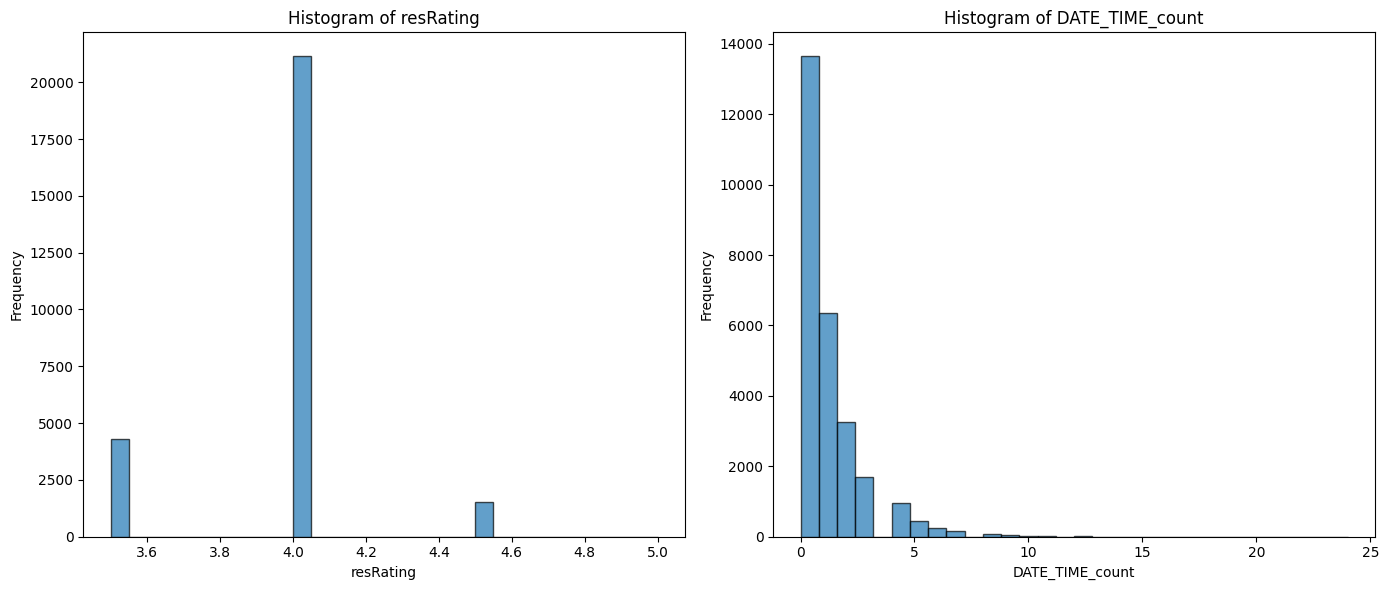

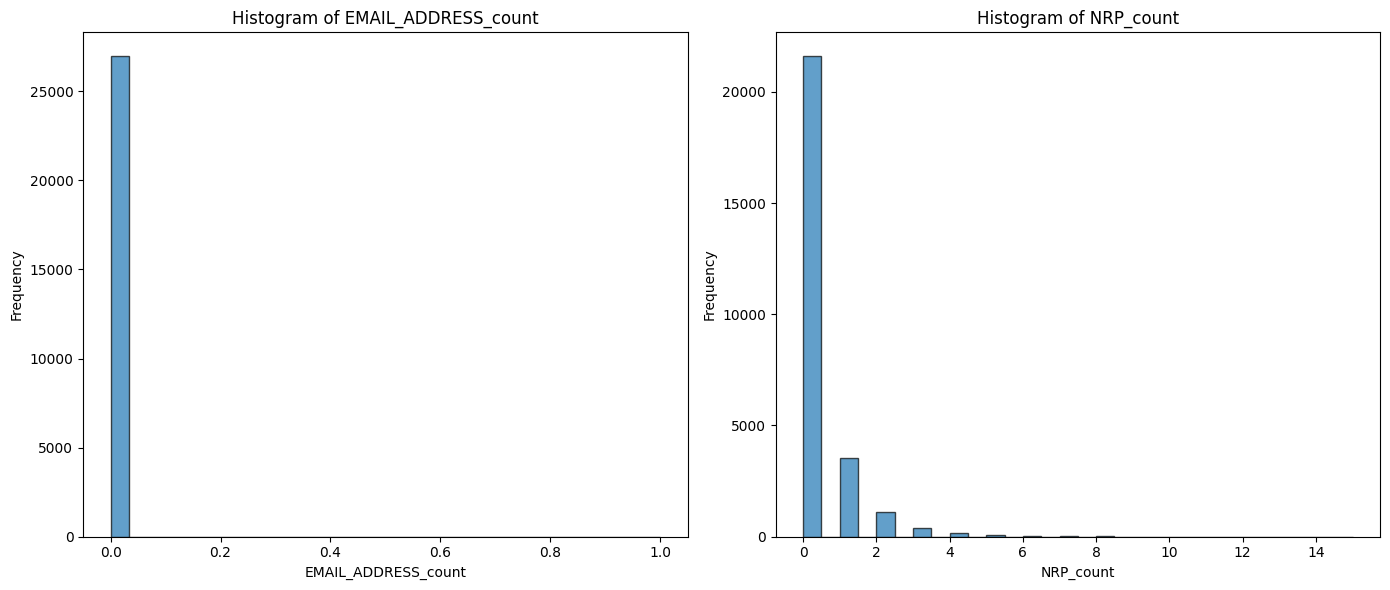

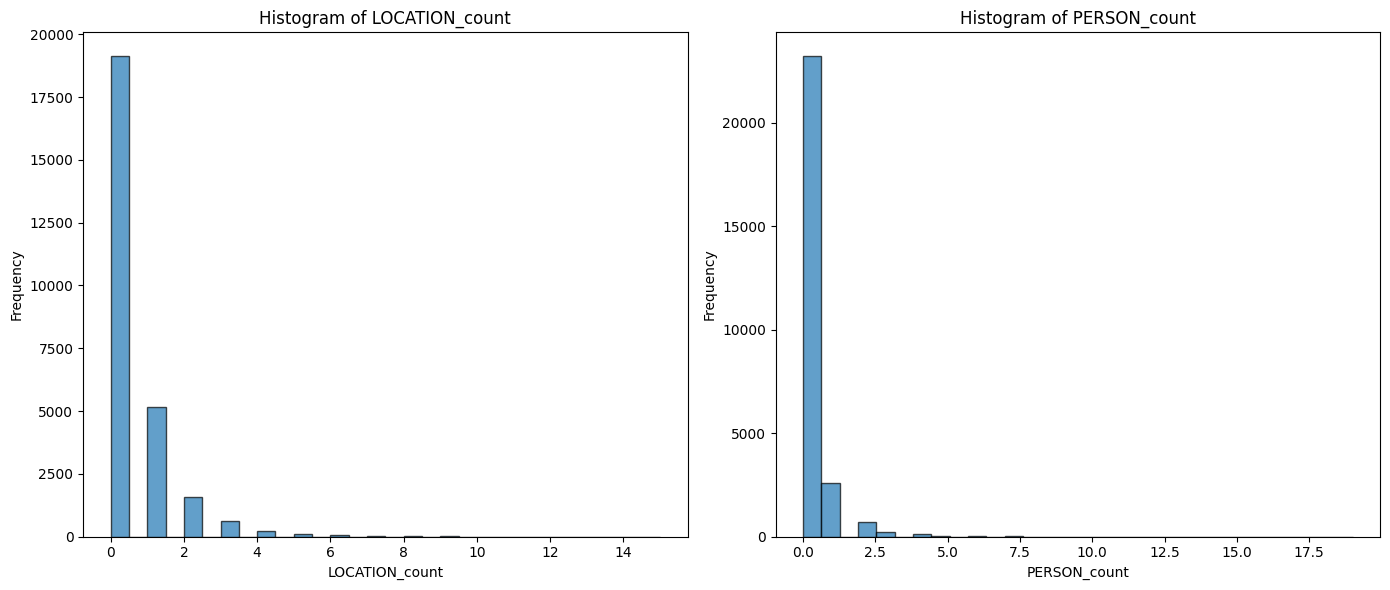

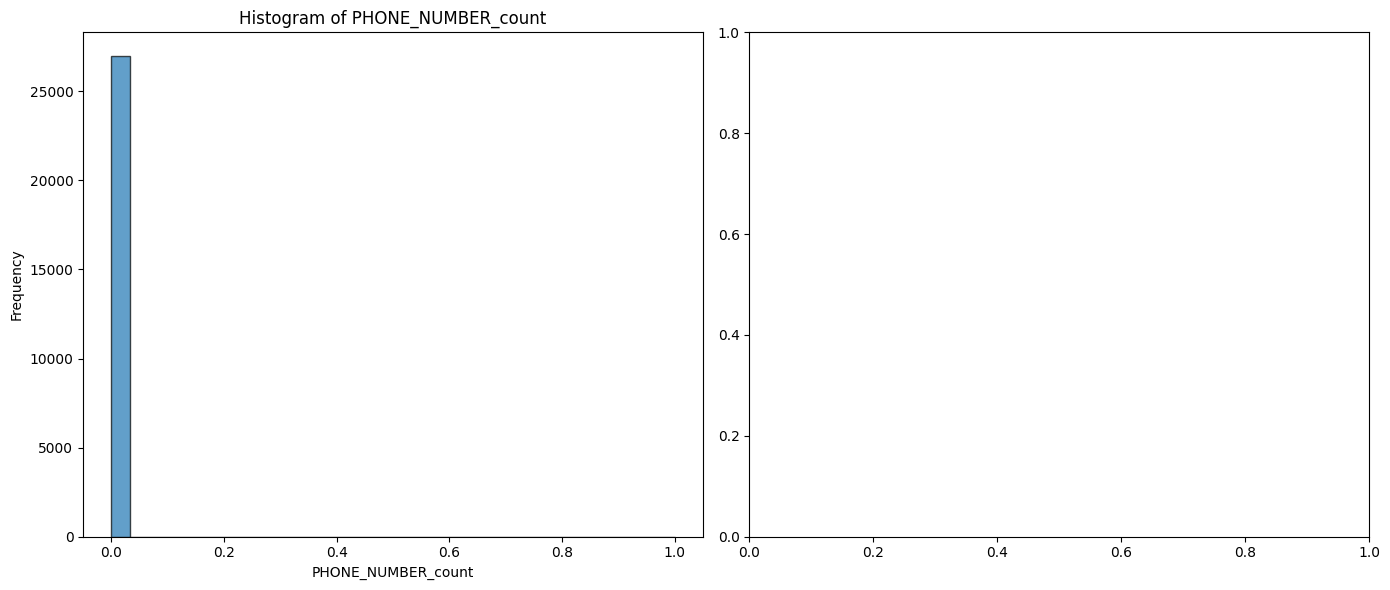

In [78]:
# summers part
# Plotting histograms in pairs
for i in range(0, len(numerical_columns), 2):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot first histogram (if exists)
    if i < len(numerical_columns):
        df[numerical_columns[i]].hist(bins=30, edgecolor='black', alpha=0.7, ax=ax[0])
        ax[0].set_title(f'Histogram of {numerical_columns[i]}')
        ax[0].set_xlabel(numerical_columns[i])
        ax[0].set_ylabel('Frequency')
        ax[0].grid(False)
    
    # Plot second histogram (if exists)
    if i+1 < len(numerical_columns):
        df[numerical_columns[i+1]].hist(bins=30, edgecolor='black', alpha=0.7, ax=ax[1])
        ax[1].set_title(f'Histogram of {numerical_columns[i+1]}')
        ax[1].set_xlabel(numerical_columns[i+1])
        ax[1].set_ylabel('Frequency')
        ax[1].grid(False)
    
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Funny')

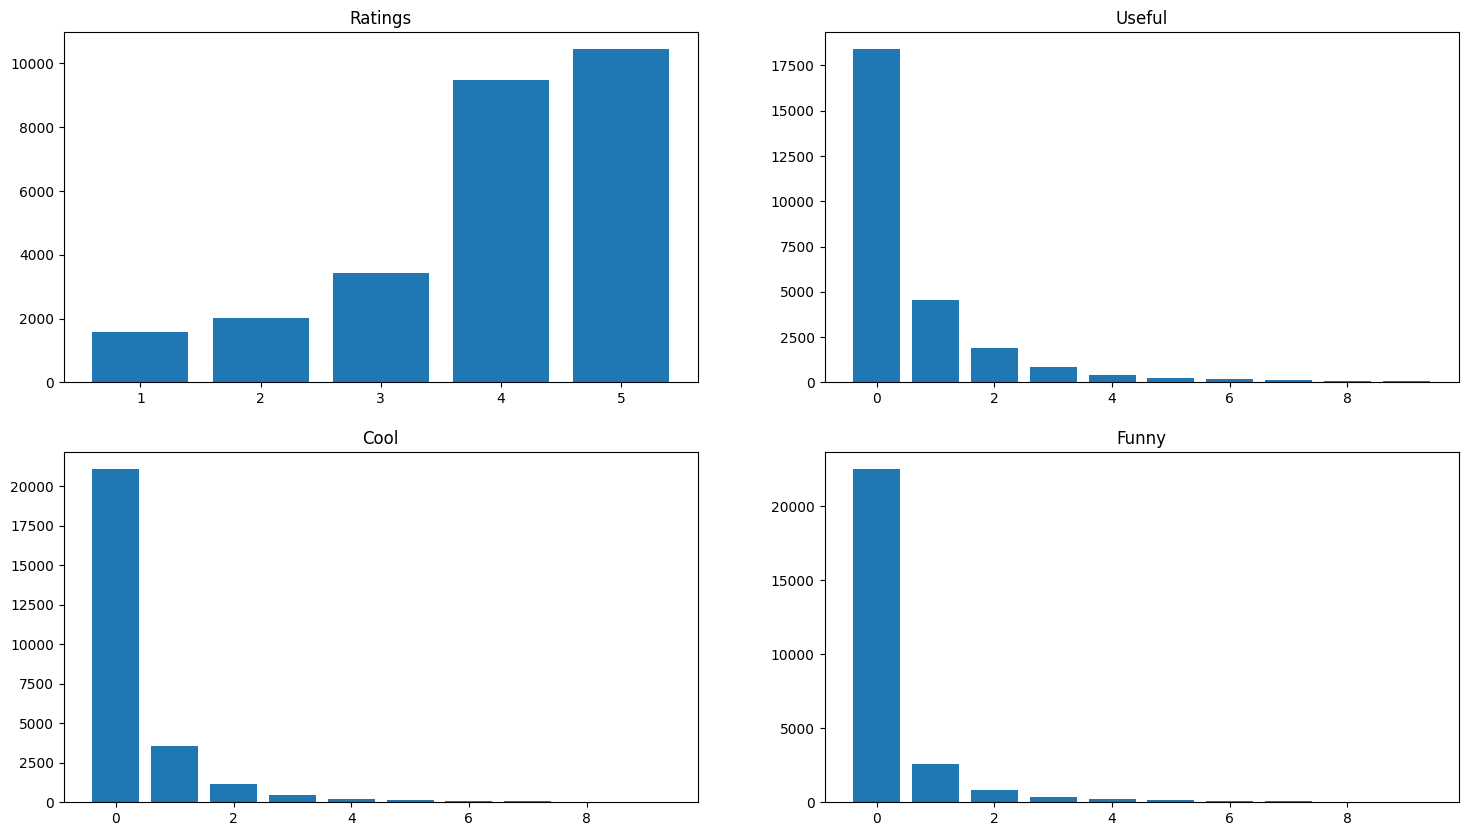

In [79]:
# individual histograms of variables
fig, axs = plt.subplots(2, 2, figsize=(18,10))

axs[0,0].bar(rating_count.index, rating_count)
axs[0,0].set_title('Ratings')

axs[0,1].bar(useful_count.index, useful_count)
axs[0,1].set_title('Useful')

axs[1,0].bar(cool_count.index, cool_count)
axs[1,0].set_title('Cool')

axs[1,1].bar(funny_count.index, funny_count)
axs[1,1].set_title('Funny')

In [80]:
df.head()

reviewDate                reviewID              reviewerID  \
0  9/22/2012  GtwU21YOQn-wf4vWRUIx6w  bNYesZ944s6IJVowOnB0iA   
1  9/22/2012                 0LpVTc3  TRKxLC3y-ZvP45e5iilMtw   
2  9/19/2012           tljtLzf68Fkwf  0EMm8umAqXZzyhxNpL4M9g   
3   9/6/2012                     iSN  DlwexC7z88ymAzu45skODw   
4   9/9/2012                  Jmwrh7  kW2dk1CWihmh3g7k9N2G8A   

                                       reviewContent  reviewRating  \
0  Unlike Next, which we'd eaten at the previous ...             5   
1  Probably one of the best meals I've had ever. ...             5   
2  Service was impeccable. Experience and present...             3   
3  The problem with places like this, given the e...             3   
4  I have no idea how to write my review - dining...             5   

   reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                  0                0                 0   
1                  0                0                 0   
2                  2                0                 0   
3                  8                0                 3   
4                  1                2                 0   

             restaurantID  flagged  ... PERSON_count PHONE_NUMBER_count  \
0  pbEiXam9YJL3neCYHGwLUA        0  ...            4                  0   
1  pbEiXam9YJL3neCYHGwLUA        0  ...            1                  0   
2  pbEiXam9YJL3neCYHGwLUA        0  ...            0                  0   
3  pbEiXam9YJL3neCYHGwLUA        0  ...            2                  0   
4  pbEiXam9YJL3neCYHGwLUA        0  ...            0                  0   

  DATE_TIME_flag  EMAIL_ADDRESS_flag  NRP_flag  LOCATION_flag  PERSON_flag  \
0              1                   0         1              0            1   
1              1                   0         0              0            1   
2              0                   0         0              0            0   
3              1                   0         0              0            1   
4              1                   0         1              1            0   

   PHONE_NUMBER_flag  reviewDate2  date_diff_joinedandreviewed  
0                  0   2012-09-22                         1087  
1                  0   2012-09-22                          479  
2                  0   2012-09-19                         1479  
3                  0   2012-09-06                         1802  
4                  0   2012-09-09                         1897  

[5 rows x 46 columns]

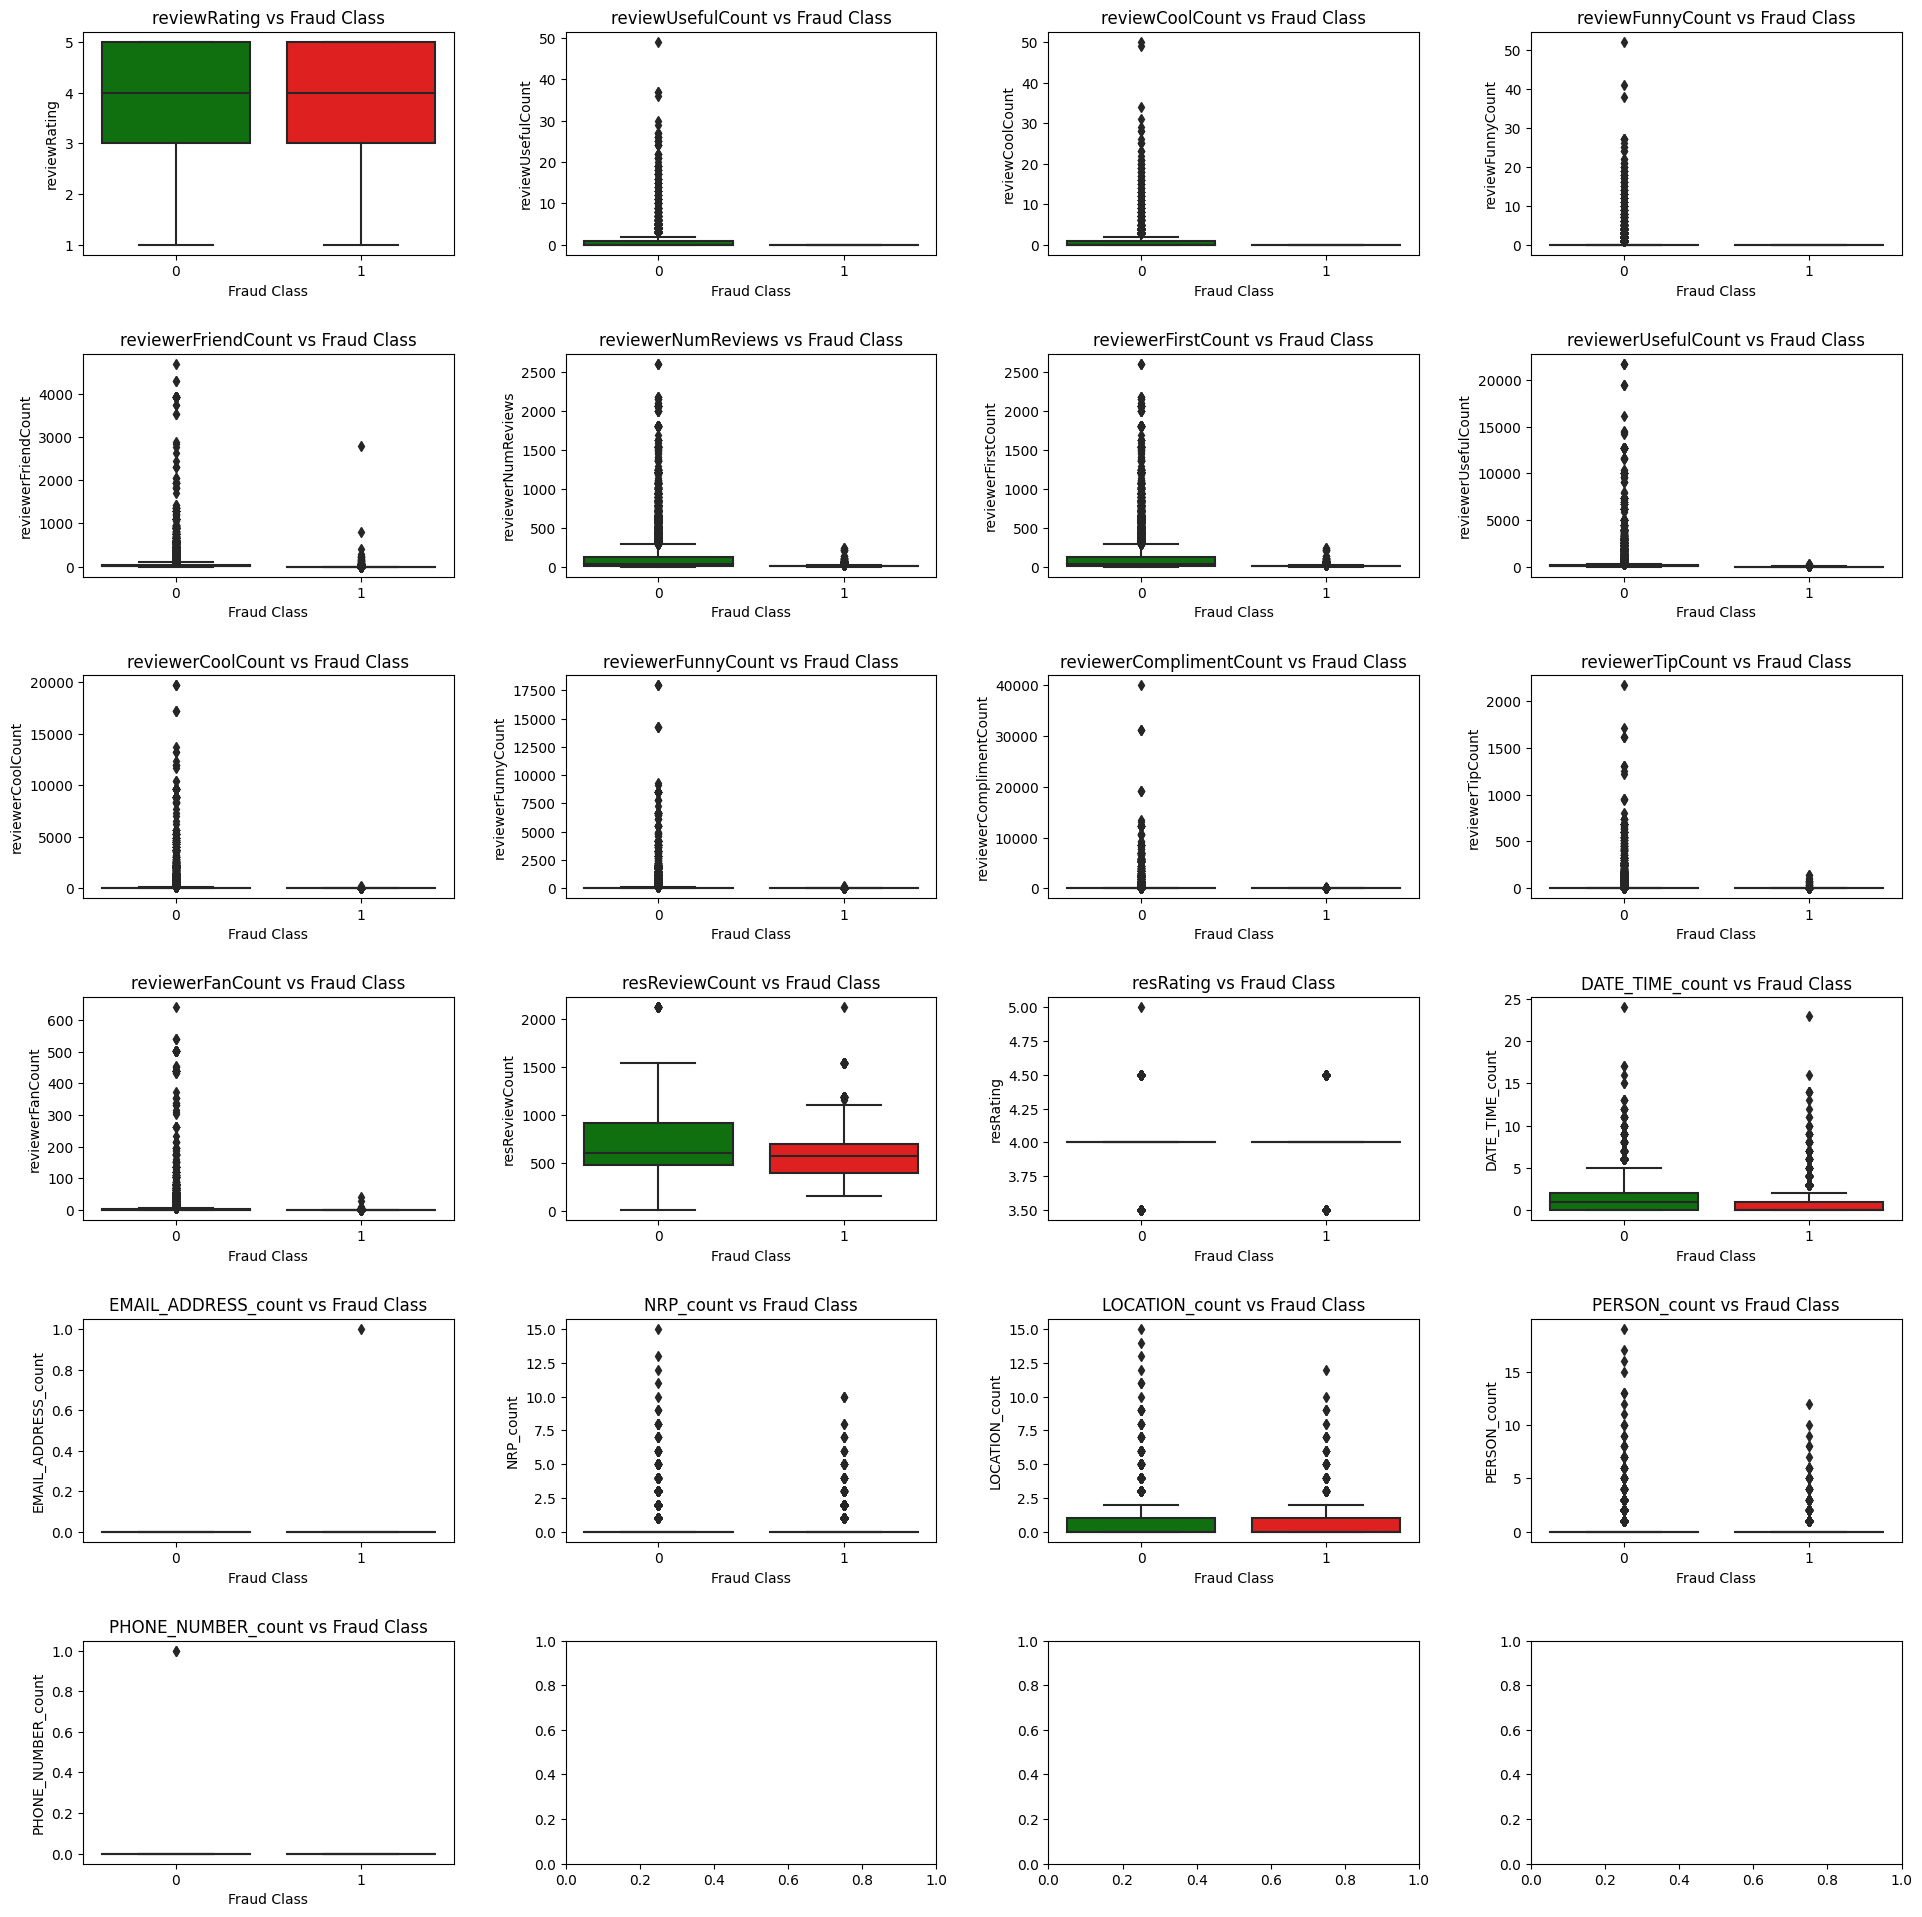

In [81]:
n_rows = 6
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.tight_layout(pad=5)

for ax, column in zip(axes.ravel(), numerical_columns):
    sns.boxplot(x="flagged", y=column, data=df, palette={1: "red", 0: "green"}, ax=ax)
    ax.set_title(column + " vs Fraud Class")
    ax.set_ylabel(column)
    ax.set_xlabel("Fraud Class")

plt.show()

In [82]:
# import math 
# n_cols = 3

# # Calculate the number of rows needed
# n_rows = math.ceil(len(cat_columns[-6:]) / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))  # Adjusted figsize

# # Flat axes for easier iteration
# axes_flat = axes.ravel()

# for idx, col in enumerate(cat_columns[-6:]):
#     # Group by the categorical column and compute mean of 'flagged'
#     col_fraud = df.groupby(col)['flagged'].mean()
    
#     # Plot
#     if col_fraud.nunique() > 2:  # Use pointplot if more than 2 unique values
#         sns.pointplot(x=col_fraud.index, y=col_fraud.values, ax=axes_flat[idx])
#     else:  # Use barplot otherwise
#         sns.barplot(x=col_fraud.index, y=col_fraud.values, ax=axes_flat[idx])
    
#     # Set title and labels
#     axes_flat[idx].set_title(f'{col} vs Fraud Rate', fontsize=10)
#     axes_flat[idx].set_ylabel('Fraud Rate', fontsize=8)
#     axes_flat[idx].set_xlabel(col, fontsize=8)
#     axes_flat[idx].tick_params(axis='both', which='major', labelsize=7)

# # If there are any remaining unused subplots, hide them
# for idx in range(len(filtered_cat), n_cols * n_rows):
#     axes_flat[idx].axis('off')

# plt.tight_layout()
# plt.show()

In [83]:
# # individual histograms of variables
# fig, axs = plt.subplots(3, 2, figsize=(18,10))

# axs[0,0].bar(datetime_count.index, rating_count)
# axs[0,0].set_title('Ratings')

# axs[0,1].bar(email_count.index, useful_count)
# axs[0,1].set_title('Useful')

# axs[1,0].bar(nrp_count.index, cool_count)
# axs[1,0].set_title('Cool')

# axs[1,1].bar(location_count.index, funny_count)
# axs[1,1].set_title('Funny')

# axs[2,1].bar(person_count.index, funny_count)
# axs[1,1].set_title('Funny')

# axs[2,1].bar(phone_count.index, funny_count)
# axs[1,1].set_title('Funny')

```Clean date data and OHE```

In [84]:
#feature engineer date

#sort by date
num_df.sort_values('reviewDate')
#drop weird dates
num_df_clean = num_df[(num_df['reviewDate'].str.len() <= 10) | (num_df['reviewDate'].str.len() >= 8)]
num_df_clean = num_df_clean[~num_df_clean['reviewDate'].str.contains('Update')]
num_df_clean = num_df_clean[~num_df_clean['reviewDate'].str.contains('\n')]

#sort by dates
num_df_sorted = num_df_clean.sort_values('reviewDate')
num_df_sorted

reviewerID reviewDate  flagged            restaurantID  \
23987  xzNMMZNG-vImvP73tUsQKw   1/1/2006        0  RYw_no9ohtCg09aKorVffg   
332    cWLSaEabp-BJq6XmovsZIQ   1/1/2007        0  pbEiXam9YJL3neCYHGwLUA   
25399  kcaCt7o3RfgMYZmtf7qlEQ   1/1/2008        1  43rd1LKcZRIunySzbMsyLQ   
10218  kmcdzKMT_XXYMjaTK-D63w   1/1/2009        0  ms5ge1XY9-Alu7HkybAMdQ   
7787   K8rs_mDMl03GPOUuJzXPxA   1/1/2009        0  CwPi6NVuJIZZx4IBcTekFQ   
...                       ...        ...      ...                     ...   
5676   d8cP4i7Ws0k2VC-AmrDWzQ   9/9/2012        0  hylBw5ND7XyPldM6BN28vw   
10516  UKnzWXa4nKQ6jM3SfMZikQ   9/9/2012        0  4wreIFjaPMppyEnzKHbozg   
8169   -HQGG_AMQcRZs9XJ2gd5Lg   9/9/2012        0  tCkwBTuEFvhuaBoEUWqbuQ   
11013  EhXudXfe67jVQc0Dgs7YdQ   9/9/2012        0  -pO0hsi0xlF4FwqLGJUizg   
16425  Xld99g8jJEeAU9OohR_bng   9/9/2012        0  euO3-H92LCivH2B0CQPlnw   

       reviewRating  reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
23987             3                  1                0                 0   
332               5                  3                1                 0   
25399             5                  0                0                 0   
10218             5                  0                0                 0   
7787              4                  4                1                 1   
...             ...                ...              ...               ...   
5676              4                  0                0                 0   
10516             5                  0                0                 0   
8169              2                  0                0                 0   
11013             2                  0                0                 0   
16425             5                  0                0                 0   

       reviewerFriendCount  reviewerNumReviews  ...  reviewerTipCount  \
23987                    6                  29  ...                 0   
332                     13                  72  ...                 0   
25399                    0                   2  ...                 0   
10218                    9                  29  ...                 0   
7787                     3                  14  ...                 0   
...                    ...                 ...  ...               ...   
5676                    22                  55  ...                27   
10516                    2                   4  ...                 1   
8169                    22                 195  ...                89   
11013                    0                  33  ...                 0   
16425                    0                   4  ...                 0   

       reviewerFanCount  resReviewCount  resRating  DATE_TIME_count  \
23987                 0             459        3.5                1   
332                   3             841        4.5                5   
25399                 0             693        4.5                0   
10218                 1             520        3.5                0   
7787                  0             727        3.5                4   
...                 ...             ...        ...              ...   
5676                  2             616        4.0                0   
10516                 0             828        3.5                0   
8169                  2             541        4.0                1   
11013                 0             417        4.0                0   
16425                 0             543        4.0                1   

       EMAIL_ADDRESS_count  NRP_count  LOCATION_count  PERSON_count  \
23987                    0          0               1             0   
332                      0          0               1             0   
25399                    0          0               0             0   
10218                    0          0               1             0   
7787                     0          0               1             0   
...          

In [85]:
#OHE on dates

num_df_sorted['reviewDate'] = pd.to_datetime(num_df_sorted['reviewDate'])
num_df_sorted['year'] = num_df_sorted['reviewDate'].dt.year
num_df_sorted['month'] = num_df_sorted['reviewDate'].dt.month
num_df_sorted['day'] = num_df_sorted['reviewDate'].dt.day
num_df_sorted

reviewerID reviewDate  flagged            restaurantID  \
23987  xzNMMZNG-vImvP73tUsQKw 2006-01-01        0  RYw_no9ohtCg09aKorVffg   
332    cWLSaEabp-BJq6XmovsZIQ 2007-01-01        0  pbEiXam9YJL3neCYHGwLUA   
25399  kcaCt7o3RfgMYZmtf7qlEQ 2008-01-01        1  43rd1LKcZRIunySzbMsyLQ   
10218  kmcdzKMT_XXYMjaTK-D63w 2009-01-01        0  ms5ge1XY9-Alu7HkybAMdQ   
7787   K8rs_mDMl03GPOUuJzXPxA 2009-01-01        0  CwPi6NVuJIZZx4IBcTekFQ   
...                       ...        ...      ...                     ...   
5676   d8cP4i7Ws0k2VC-AmrDWzQ 2012-09-09        0  hylBw5ND7XyPldM6BN28vw   
10516  UKnzWXa4nKQ6jM3SfMZikQ 2012-09-09        0  4wreIFjaPMppyEnzKHbozg   
8169   -HQGG_AMQcRZs9XJ2gd5Lg 2012-09-09        0  tCkwBTuEFvhuaBoEUWqbuQ   
11013  EhXudXfe67jVQc0Dgs7YdQ 2012-09-09        0  -pO0hsi0xlF4FwqLGJUizg   
16425  Xld99g8jJEeAU9OohR_bng 2012-09-09        0  euO3-H92LCivH2B0CQPlnw   

       reviewRating  reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
23987             3                  1                0                 0   
332               5                  3                1                 0   
25399             5                  0                0                 0   
10218             5                  0                0                 0   
7787              4                  4                1                 1   
...             ...                ...              ...               ...   
5676              4                  0                0                 0   
10516             5                  0                0                 0   
8169              2                  0                0                 0   
11013             2                  0                0                 0   
16425             5                  0                0                 0   

       reviewerFriendCount  reviewerNumReviews  ...  resRating  \
23987                    6                  29  ...        3.5   
332                     13                  72  ...        4.5   
25399                    0                   2  ...        4.5   
10218                    9                  29  ...        3.5   
7787                     3                  14  ...        3.5   
...                    ...                 ...  ...        ...   
5676                    22                  55  ...        4.0   
10516                    2                   4  ...        3.5   
8169                    22                 195  ...        4.0   
11013                    0                  33  ...        4.0   
16425                    0                   4  ...        4.0   

       DATE_TIME_count  EMAIL_ADDRESS_count  NRP_count  LOCATION_count  \
23987                1                    0          0               1   
332                  5                    0          0               1   
25399                0                    0          0               0   
10218                0                    0          0               1   
7787                 4                    0          0               1   
...                ...                  ...        ...             ...   
5676                 0                    0          1               0   
10516                0                    0          0               0   
8169                 1                    0          1               0   
11013                0                    0          0               0   
16425                1                    0          0               0   

       PERSON_count  PHONE_NUMBER_count  year  month  day  
23987             0                   0  2006      1    1  
332               0                   0  2007      1    1  
25399             0                   0  2008      1    1  
10218             0                   0  2009      1    1  
7787              0                   0  2009      1    1  
...             ...                 ...   ...    ...  ...  
5676              0                   0  2012      9    9  
10516  

```Reviews by Year and Month```

<Axes: xlabel='year', ylabel='count'>

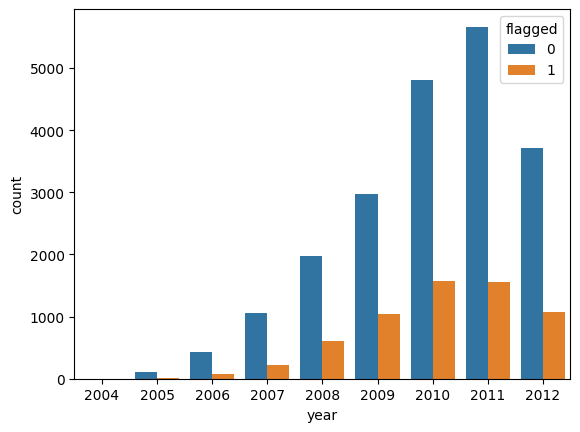

In [86]:
#reviews each year 
sns.countplot(x = 'year', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'] == 1) | (num_df_sorted['flagged'] == 0)])

<Axes: xlabel='month', ylabel='count'>

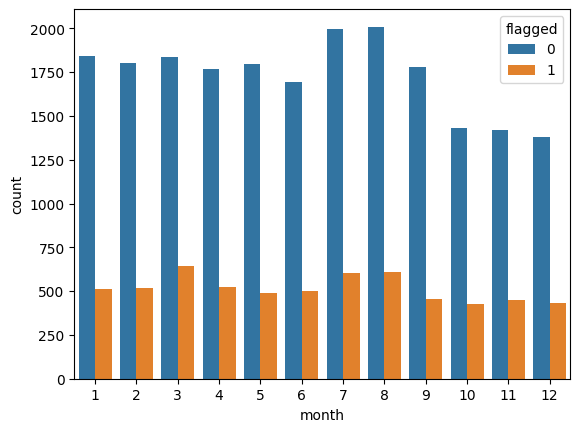

In [87]:
#reviews each month
sns.countplot(x = 'month', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'] == 1) | (num_df_sorted['flagged'] == 0)])

In [88]:
# too many reviewers / restaurants, unfeasible to do individual analysis
# len(num_df_sorted['reviewerID'].unique())
# len(num_df_sorted['restaurantID'].unique())

```Analysis on usefulCount, coolCount, and funnyCount on fraud```

<Axes: xlabel='reviewUsefulCount', ylabel='count'>

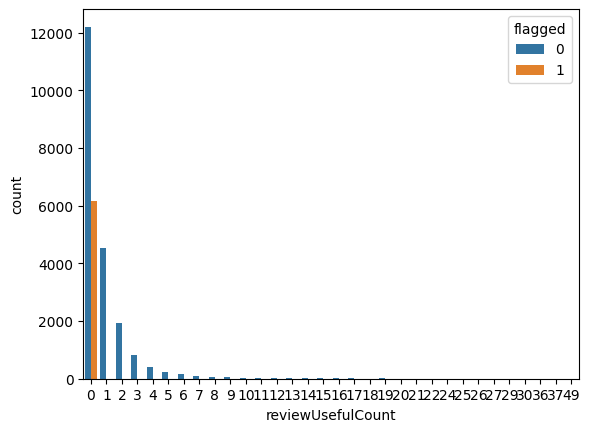

In [89]:
sns.countplot(x = 'reviewUsefulCount', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'] == 1) | (num_df_sorted['flagged'] == 0)])

In [90]:
#number of flagged reviews for reviews that have received 1 or more 'useful' 'cool' or 'funny'
r_useful_flagged = len(num_df_sorted[(num_df_sorted['reviewUsefulCount'] > 0) & (num_df_sorted['flagged'] == 1)])
r_cool_flagged = len(num_df_sorted[(num_df_sorted['reviewCoolCount'] > 0) & (num_df_sorted['flagged'] == 1)])
r_funny_flagged = len(num_df_sorted[(num_df_sorted['reviewFunnyCount'] > 0) & (num_df_sorted['flagged'] == 1)])

print(f'usefulCount >= 1, flagged as fraud: {r_useful_flagged}')
print(f'coolCount >= 1, flagged as fraud: {r_cool_flagged}')
print(f'funnyCount >= 1, flagged as fraud: {r_funny_flagged}')

#number of flagged reviews for reviewers that have received 1 or more 'useful' 'cool' or 'funny'
R_useful_flagged = len(num_df_sorted[(num_df_sorted['reviewerUsefulCount'] > 0) & (num_df_sorted['flagged'] == 1)])
R_cool_flagged = len(num_df_sorted[(num_df_sorted['reviewerCoolCount'] > 0) & (num_df_sorted['flagged'] == 1)])
R_funny_flagged = len(num_df_sorted[(num_df_sorted['reviewerFunnyCount'] > 0) & (num_df_sorted['flagged'] == 1)])

print(f'RusefulCount >= 1, flagged as fraud: {R_useful_flagged}')
print(f'RcoolCount >= 1, flagged as fraud: {R_cool_flagged}')
print(f'RfunnyCount >= 1, flagged as fraud: {R_funny_flagged}')

usefulCount >= 1, flagged as fraud: 0
coolCount >= 1, flagged as fraud: 0
funnyCount >= 1, flagged as fraud: 0
RusefulCount >= 1, flagged as fraud: 3516
RcoolCount >= 1, flagged as fraud: 2193
RfunnyCount >= 1, flagged as fraud: 1923


```Percentage of Flagged Reviews over normal reviews```

<Axes: xlabel='reviewRating', ylabel='count'>

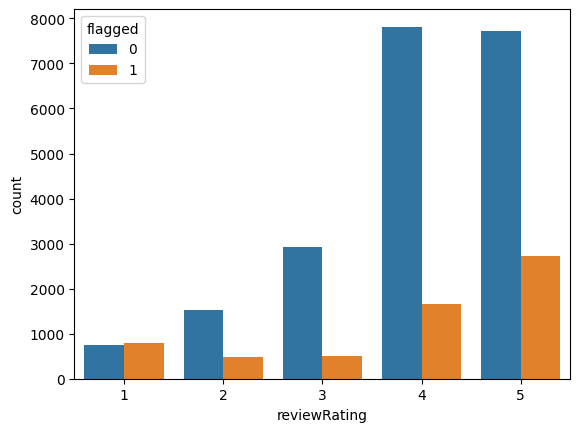

In [91]:
#flagged review count based on rating
sns.countplot(x = 'reviewRating', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'].isin([1, 0]))])

In [92]:
#percentage of fake reviews for each rating
ratio1 = len(num_df_sorted[(num_df_sorted['reviewRating'] == 1) & (num_df_sorted['flagged'] == 1)])/len(num_df_sorted[(num_df_sorted['reviewRating'] == 1)])
print(f'1 star rating: {ratio1*100}%')

ratio2 = len(num_df_sorted[(num_df_sorted['reviewRating'] == 2) & (num_df_sorted['flagged'] == 1)])/len(num_df_sorted[(num_df_sorted['reviewRating'] == 2)])
print(f'2 star rating: {ratio2*100}%')

ratio3 = len(num_df_sorted[(num_df_sorted['reviewRating'] == 3) & (num_df_sorted['flagged'] == 1)])/len(num_df_sorted[(num_df_sorted['reviewRating'] == 3)])
print(f'3 star rating: {ratio3*100}%')

ratio4 = len(num_df_sorted[(num_df_sorted['reviewRating'] == 4) & (num_df_sorted['flagged'] == 1)])/len(num_df_sorted[(num_df_sorted['reviewRating'] == 4)])
print(f'4 star rating: {ratio4*100}%')

ratio5 = len(num_df_sorted[(num_df_sorted['reviewRating'] == 5) & (num_df_sorted['flagged'] == 1)])/len(num_df_sorted[(num_df_sorted['reviewRating'] == 5)])
print(f'5 star rating: {ratio5*100}%')

1 star rating: 51.12976113621691%
2 star rating: 24.00990099009901%
3 star rating: 14.780331684608669%
4 star rating: 17.49366554054054%
5 star rating: 26.063625910310463%


In [93]:
# len(num_df_sorted[(num_df_sorted['rating'] == 1)])
# len(num_df_sorted[(num_df_sorted['rating'] == 1) & (num_df_sorted['flagged'] == 1)])

```Correlation Matrix Implementation```

In [94]:
#changed flagged to numeric boolean
num_df_sorted['flagged_n'] = num_df_sorted['flagged'].apply(lambda x : 0 if x == 0 else 1)

In [95]:
#correlation matrix
corr_matrix = num_df_sorted.corr(numeric_only=True)
print(corr_matrix)

                          flagged  reviewRating  reviewUsefulCount  \
flagged                  1.000000     -0.057327          -0.214217   
reviewRating            -0.057327      1.000000          -0.033269   
reviewUsefulCount       -0.214217     -0.033269           1.000000   
reviewCoolCount         -0.166514      0.063485           0.822516   
reviewFunnyCount        -0.141572     -0.030246           0.724126   
reviewerFriendCount     -0.111628      0.010394           0.388768   
reviewerNumReviews      -0.226103      0.014245           0.381959   
reviewerFirstCount      -0.226103      0.014245           0.381959   
reviewerUsefulCount     -0.114569      0.011620           0.491278   
reviewerCoolCount       -0.097972      0.012505           0.491471   
reviewerFunnyCount      -0.099375      0.012268           0.507740   
reviewerComplimentCount -0.075525      0.015101           0.496143   
reviewerTipCount        -0.092156      0.019263           0.185307   
reviewerFanCount    

```Correlation Matrix Heatmap```

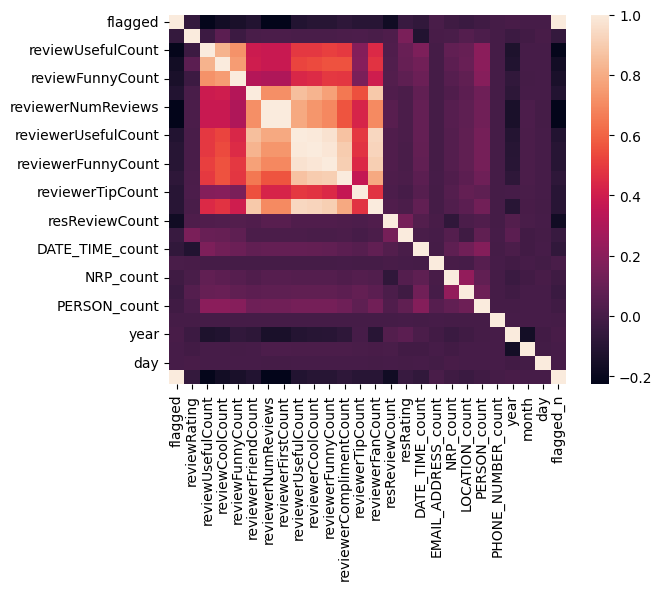

In [96]:
sns.heatmap(corr_matrix)
plt.show()

<Axes: xlabel='PERSON_count', ylabel='count'>

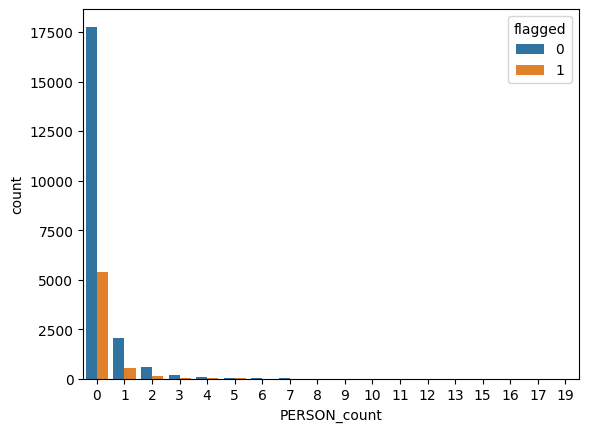

In [97]:
sns.countplot(x = 'PERSON_count', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'] == 1) | (num_df_sorted['flagged'] == 0)])

<Axes: xlabel='DATE_TIME_count', ylabel='count'>

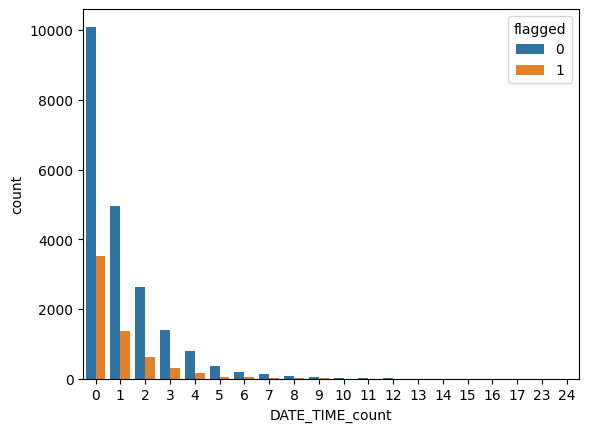

In [98]:
sns.countplot(x = 'DATE_TIME_count', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'] == 1) | (num_df_sorted['flagged'] == 0)])

In [99]:
datetime_flagged = len(num_df_sorted[(num_df_sorted['DATE_TIME_count'] > 0) & (num_df_sorted['flagged'] == 1)].index)
datetime_nflagged = len(num_df_sorted[(num_df_sorted['DATE_TIME_count'] > 0) & (num_df_sorted['flagged'] == 0)].index)

ndatetime_flagged = len(num_df_sorted[(num_df_sorted['DATE_TIME_count'] == 0) & (num_df_sorted['flagged'] == 1)].index)
ndatetime_nflagged = len(num_df_sorted[(num_df_sorted['DATE_TIME_count'] == 0) & (num_df_sorted['flagged'] == 0)].index)

print(f'precentage of flagged reviews with DATETIME = {(datetime_flagged/(datetime_flagged+datetime_nflagged))*100}%')
print(f'precentage of flagged reviews without DATETIME = {(ndatetime_flagged/(ndatetime_flagged+ndatetime_nflagged))*100}%')

precentage of flagged reviews with DATETIME = 19.832969678729967%
precentage of flagged reviews without DATETIME = 25.882698377743523%


In [100]:
location_flagged = len(num_df_sorted[(num_df_sorted['LOCATION_count'] > 0) & (num_df_sorted['flagged'] == 1)].index)
location_nflagged = len(num_df_sorted[(num_df_sorted['LOCATION_count'] > 0) & (num_df_sorted['flagged'] == 0)].index)

nlocation_flagged = len(num_df_sorted[(num_df_sorted['LOCATION_count'] == 0) & (num_df_sorted['flagged'] == 1)].index)
nlocation_nflagged = len(num_df_sorted[(num_df_sorted['LOCATION_count'] == 0) & (num_df_sorted['flagged'] == 0)].index)

print(f'precentage of flagged reviews with LOCATION = {(location_flagged/(location_flagged+location_nflagged))*100}%')
print(f'precentage of flagged reviews without LOCATION = {(nlocation_flagged/(nlocation_flagged+nlocation_nflagged))*100}%')

precentage of flagged reviews with LOCATION = 20.505940973553084%
precentage of flagged reviews without LOCATION = 23.87488866767957%


In [101]:
email_address_flagged = len(num_df_sorted[(num_df_sorted['EMAIL_ADDRESS_count'] > 0) & (num_df_sorted['flagged'] == 1)].index)
email_address_nflagged = len(num_df_sorted[(num_df_sorted['EMAIL_ADDRESS_count'] > 0) & (num_df_sorted['flagged'] == 0)].index)

nemail_address_flagged = len(num_df_sorted[(num_df_sorted['EMAIL_ADDRESS_count'] == 0) & (num_df_sorted['flagged'] == 1)].index)
nemail_address_nflagged = len(num_df_sorted[(num_df_sorted['EMAIL_ADDRESS_count'] == 0) & (num_df_sorted['flagged'] == 0)].index)

print(f'precentage of flagged reviews with EMAIL ADDRESS = {(email_address_flagged/(email_address_flagged+email_address_nflagged))*100}%')
print(f'precentage of flagged reviews without EMAIL ADDRESS = {(nemail_address_flagged/(nemail_address_flagged+nemail_address_nflagged))*100}%')

precentage of flagged reviews with EMAIL ADDRESS = 100.0%
precentage of flagged reviews without EMAIL ADDRESS = 22.892282540036412%


In [102]:
person_flagged = len(num_df_sorted[(num_df_sorted['PERSON_count'] > 0) & (num_df_sorted['flagged'] == 1)].index)
person_nflagged = len(num_df_sorted[(num_df_sorted['PERSON_count'] > 0) & (num_df_sorted['flagged'] == 0)].index)

nperson_flagged = len(num_df_sorted[(num_df_sorted['PERSON_count'] == 0) & (num_df_sorted['flagged'] == 1)].index)
nperson_nflagged = len(num_df_sorted[(num_df_sorted['PERSON_count'] == 0) & (num_df_sorted['flagged'] == 0)].index)

print(f'precentage of flagged reviews with PERSON = {(person_flagged/(person_flagged+person_nflagged))*100}%')
print(f'precentage of flagged reviews without PERSON = {(nperson_flagged/(nperson_flagged+nperson_nflagged))*100}%')

print(email_address_flagged)
print(email_address_nflagged)

precentage of flagged reviews with PERSON = 20.48481619605754%
precentage of flagged reviews without PERSON = 23.285837651122627%
1
0


In [103]:
NRP_flagged = len(num_df_sorted[(num_df_sorted['NRP_count'] > 0) & (num_df_sorted['flagged'] == 1)].index)
NRP_nflagged = len(num_df_sorted[(num_df_sorted['NRP_count'] > 0) & (num_df_sorted['flagged'] == 0)].index)

nNRP_flagged = len(num_df_sorted[(num_df_sorted['NRP_count'] == 0) & (num_df_sorted['flagged'] == 1)].index)
nNRP_nflagged = len(num_df_sorted[(num_df_sorted['NRP_count'] == 0) & (num_df_sorted['flagged'] == 0)].index)

print(f'precentage of flagged reviews with NRP = {(NRP_flagged/(NRP_flagged+NRP_nflagged))*100}%')
print(f'precentage of flagged reviews without NRP = {(nNRP_flagged/(nNRP_flagged+nNRP_nflagged))*100}%')

precentage of flagged reviews with NRP = 21.321882001493652%
precentage of flagged reviews without NRP = 23.28601911123481%


In [104]:
phone_number_flagged = len(num_df_sorted[(num_df_sorted['PHONE_NUMBER_count'] > 0) & (num_df_sorted['flagged'] == 1)].index)
phone_number_nflagged = len(num_df_sorted[(num_df_sorted['PHONE_NUMBER_count'] > 0) & (num_df_sorted['flagged'] == 0)].index)

nphone_number_flagged = len(num_df_sorted[(num_df_sorted['PHONE_NUMBER_count'] == 0) & (num_df_sorted['flagged'] == 1)].index)
nphone_number_nflagged = len(num_df_sorted[(num_df_sorted['PHONE_NUMBER_count'] == 0) & (num_df_sorted['flagged'] == 0)].index)

print(f'precentage of flagged reviews with PHONE NUMBER = {(phone_number_flagged/(phone_number_flagged+phone_number_nflagged))*100}%')
print(f'precentage of flagged reviews without PHONE NUMBER = {(nphone_number_flagged/(nphone_number_flagged+nphone_number_nflagged))*100}%')

print(phone_number_flagged)
print(phone_number_nflagged)

precentage of flagged reviews with PHONE NUMBER = 0.0%
precentage of flagged reviews without PHONE NUMBER = 22.896848989298455%
0
2


<Axes: xlabel='reviewerNumReviews', ylabel='count'>

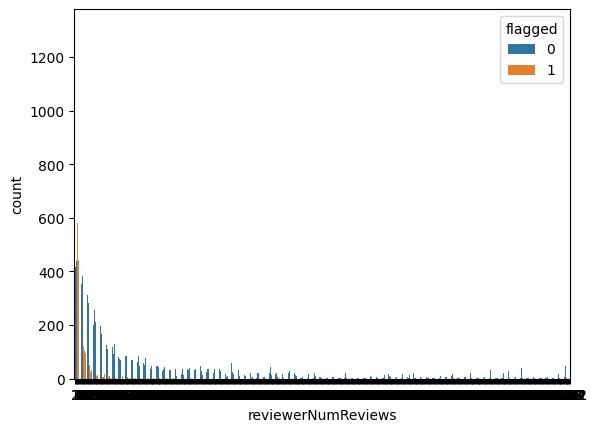

In [105]:
sns.countplot(x = 'reviewerNumReviews', hue = 'flagged', data = num_df_sorted[(num_df_sorted['flagged'] == 1) | (num_df_sorted['flagged'] == 0)])

In [106]:
reviewerNumReviews_causes_flagged = grangercausalitytests(num_df_sorted[['reviewerNumReviews', 'flagged_n']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2147  , p=0.6431  , df_denom=26910, df_num=1
ssr based chi2 test:   chi2=0.2147  , p=0.6431  , df=1
likelihood ratio test: chi2=0.2147  , p=0.6431  , df=1
parameter F test:         F=0.2147  , p=0.6431  , df_denom=26910, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5504  , p=0.5767  , df_denom=26907, df_num=2
ssr based chi2 test:   chi2=1.1009  , p=0.5767  , df=2
likelihood ratio test: chi2=1.1009  , p=0.5767  , df=2
parameter F test:         F=0.5504  , p=0.5767  , df_denom=26907, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5254  , p=0.6648  , df_denom=26904, df_num=3
ssr based chi2 test:   chi2=1.5765  , p=0.6647  , df=3
likelihood ratio test: chi2=1.5765  , p=0.6647  , df=3
parameter F test:         F=0.5254  , p=0.6648  , df_denom=26904, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0423  

# Raw text columns

Length of each review (how many words and characters in each review)

In [9]:
# Handle NaN values in the 'reviewContent' column (replace with an empty string)
df['reviewContent'].fillna('', inplace=True)

# Calculate word and character counts for each review
df['word_count'] = df['reviewContent'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['reviewContent'].apply(lambda x: len(str(x)))

# Summary statistics for word counts and character counts
word_count_stats = df['word_count'].describe()
char_count_stats = df['char_count'].describe()

print("Word Count Statistics:")
print(word_count_stats)

print("\nCharacter Count Statistics:")
print(char_count_stats)

Word Count Statistics:
count    26956.000000
mean       133.409964
std        119.199309
min          1.000000
25%         53.000000
50%        100.000000
75%        176.000000
max        971.000000
Name: word_count, dtype: float64

Character Count Statistics:
count    26956.000000
mean       724.330798
std        648.884777
min          1.000000
25%        290.000000
50%        540.000000
75%        952.000000
max       4996.000000
Name: char_count, dtype: float64


Word cloud

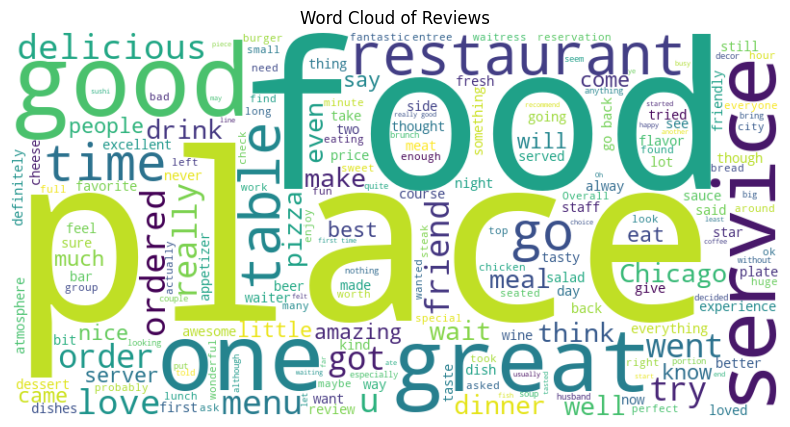

In [7]:
text = " ".join(review for review in df['reviewContent'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

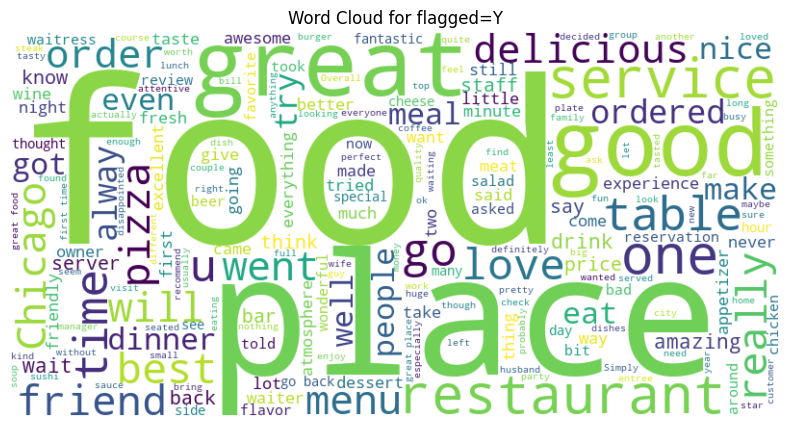

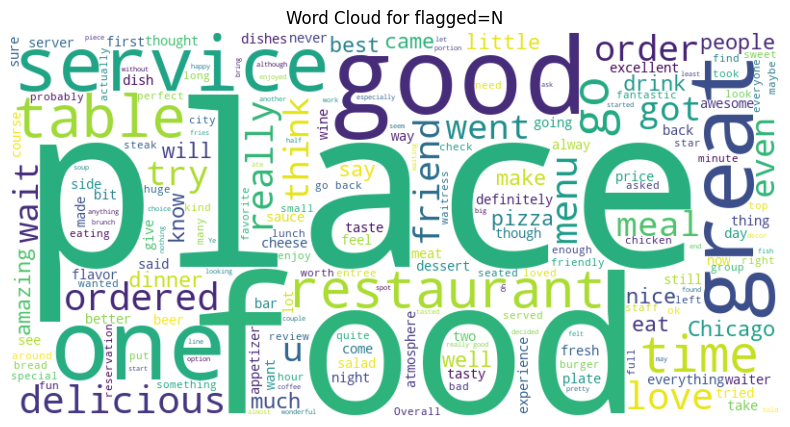

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(flagged_value, df):
    subset_df = df[df['flagged'] == flagged_value]

    text = ' '.join(subset_df['reviewContent'].astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for flagged={flagged_value}')
    plt.show()

generate_word_cloud('Y', df)

generate_word_cloud('N', df)

Tokenisation

In [10]:
tokenizer = WordPunctTokenizer()
df['tokens'] = df['reviewContent'].apply(tokenizer.tokenize)


def preprocess_text(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens]  
    tokens = [word for word in tokens if word not in stop_words] 
    tokens = [word for word in tokens if word not in string.punctuation] 
    tokens = [word for word in tokens if len(word) > 1]  
    return tokens

df['clean_tokens'] = df['tokens'].apply(preprocess_text)

df['clean_text'] = df['clean_tokens'].apply(lambda x: ' '.join(x))

N-gram analysis (common phrases)

In [11]:
from nltk.util import ngrams
from collections import Counter
ngram_range = 2 

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

df['ngrams'] = df['clean_tokens'].apply(lambda x: extract_ngrams(x, ngram_range))

all_ngrams = [ngram for ngram_list in df['ngrams'] for ngram in ngram_list]

ngram_freq = Counter(all_ngrams)

most_common_ngrams = ngram_freq.most_common(10)
for ngram, freq in most_common_ngrams:
    print(f"N-gram: {' '.join(ngram)} - Frequency: {freq}")

N-gram: go back - Frequency: 2121
N-gram: really good - Frequency: 1303
N-gram: first time - Frequency: 1154
N-gram: food good - Frequency: 1143
N-gram: great food - Frequency: 1094
N-gram: deep dish - Frequency: 1061
N-gram: pretty good - Frequency: 1013
N-gram: food great - Frequency: 980
N-gram: great place - Frequency: 941
N-gram: love place - Frequency: 916


Find most common phrases of fake vs real reviews

In [12]:
from nltk.util import ngrams
from collections import Counter

ngram_range = 2

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

df['ngrams'] = df['clean_tokens'].apply(lambda x: extract_ngrams(x, ngram_range))

def most_common_ngrams_for_flagged(flagged_value, df):
    subset_df = df[df['flagged'] == flagged_value]

    all_ngrams = [ngram for ngram_list in subset_df['ngrams'] for ngram in ngram_list]

    ngram_freq = Counter(all_ngrams)

    most_common_ngrams = ngram_freq.most_common(10)
    print(f"Most common n-grams for flagged={flagged_value}:")
    for ngram, freq in most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)} - Frequency: {freq}")

most_common_ngrams_for_flagged('Y', df)

most_common_ngrams_for_flagged('N', df)

Most common n-grams for flagged=Y:
N-gram: go back - Frequency: 391
N-gram: great food - Frequency: 359
N-gram: food good - Frequency: 279
N-gram: great place - Frequency: 275
N-gram: food great - Frequency: 272
N-gram: love place - Frequency: 266
N-gram: first time - Frequency: 258
N-gram: good food - Frequency: 230
N-gram: salad bar - Frequency: 224
N-gram: great service - Frequency: 217
Most common n-grams for flagged=N:
N-gram: go back - Frequency: 1730
N-gram: really good - Frequency: 1134
N-gram: deep dish - Frequency: 900
N-gram: first time - Frequency: 896
N-gram: pretty good - Frequency: 876
N-gram: food good - Frequency: 864
N-gram: next time - Frequency: 768
N-gram: great food - Frequency: 735
N-gram: come back - Frequency: 717
N-gram: food great - Frequency: 708


### Text Reviews Preprocessing

In [112]:
nltk.download('stopwords')
nltk.download('wordnet')

stopwords = nltk.corpus.stopwords.words('english')

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

def preprocess(text):
    text = remove_punctuation(text)
    text = text.lower()
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return text

df['preprocessed'] = df['reviewContent'].apply(lambda x: preprocess(x))

print(df[['reviewContent', 'preprocessed']])

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                           reviewContent  \
0      Unlike Next, which we'd eaten at the previous ...   
1      Probably one of the best meals I've had ever. ...   
2      Service was impeccable. Experience and present...   
3      The problem with places like this, given the e...   
4      I have no idea how to write my review - dining...   
...                                                  ...   
26951  It's Taco Bell, with higher prices, but it's T...   
26952  Yellow Rose is a favorite of mine. I'd go ther...   
26953  Not bad. We ate there because the odd wicker s...   
26954  We were surprised to have been eagerly roped i...   
26955  A gorgeous shy young teen asked the owner if s...   

                                            preprocessed  
0      [unlike, next, wed, eaten, previous, night, di...  
1      [probably, one, best, meal, ive, ever, perform...  
2      [service, impeccable, experience, presentation...  
3      [problem, place, like, given, exhorb

In [119]:
df["flagged"] = df["flagged"].replace({"N":0, "Y": 1})

### Comparing Topics between Fradulent and Non-Fradulent Class

/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/2888253936.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["flagged"]==0]["main_topic"], shade=True, color="green", label="Genuine", ax=ax)
/var/folders/1t/nll74_0j61918pgb1cz1kwsr0000gn/T/ipykernel_8905/2888253936.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["flagged"]==1]["main_topic"], shade=True, color="blue", label="Fraudulent", ax=ax)


Text(0.5, 0.98, 'Main Topic vs Fraud Class')

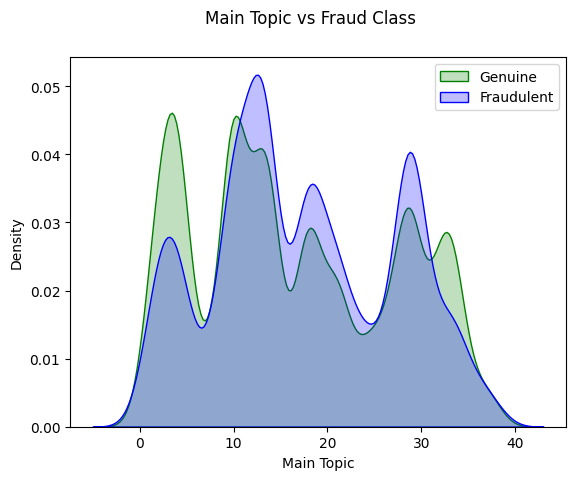

In [120]:
fig, ax = plt.subplots()
sns.kdeplot(df[df["flagged"]==0]["main_topic"], shade=True, color="green", label="Genuine", ax=ax)

sns.kdeplot(df[df["flagged"]==1]["main_topic"], shade=True, color="blue", label="Fraudulent", ax=ax)
ax.set_xlabel("Main Topic")
ax.set_ylabel("Density")
ax.legend()
fig.suptitle("Main Topic vs Fraud Class")

In [121]:
df.to_csv("../datasets/Preprocessed_data.csv")

### Creating BoxPlot Function 

In [122]:
def new_boxplot(x,y,data,title,ylabel, xlabel):
    fig, ax = plt.subplots()

    sns.boxplot(x=x, y=y, data=data, palette={1: "red", 0: "green"}, ax=ax)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    plt.show()

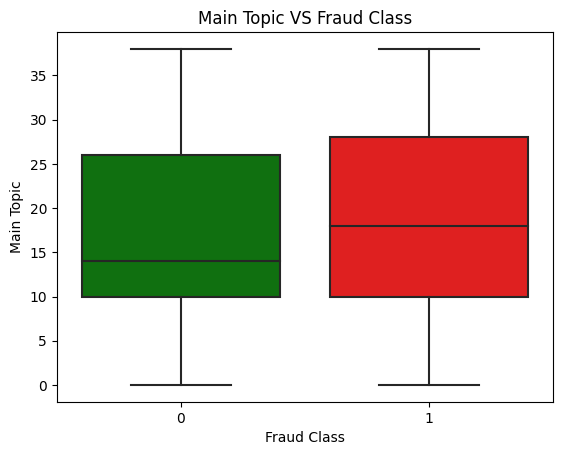

In [123]:
new_boxplot("flagged", "main_topic", df, "Main Topic VS Fraud Class", "Main Topic", "Fraud Class")


In [124]:
description = df.groupby('flagged')['main_topic'].describe()
print(description)

           count       mean        std  min   25%   50%   75%   max
flagged                                                            
0        20752.0  16.552814  10.475505  0.0  10.0  14.0  26.0  38.0
1         6204.0  17.408930   9.599152  0.0  10.0  18.0  28.0  38.0


### Visualisations on the number of characters in the review texts

In [125]:
reviewFeatures = pd.DataFrame()

In [126]:
num_chars = df["reviewContent"].apply(lambda x: len(x))
num_chars.describe()

count    26956.000000
mean       724.330798
std        648.884777
min          1.000000
25%        290.000000
50%        540.000000
75%        952.000000
max       4996.000000
Name: reviewContent, dtype: float64

In [127]:
reviewFeatures["Num_Chars"] = num_chars


In [128]:
num_char_real = df[df["flagged"]==0]["reviewContent"].apply(lambda x: len(x))
num_char_flagged = df[df["flagged"]==1]["reviewContent"].apply(lambda x: len(x))


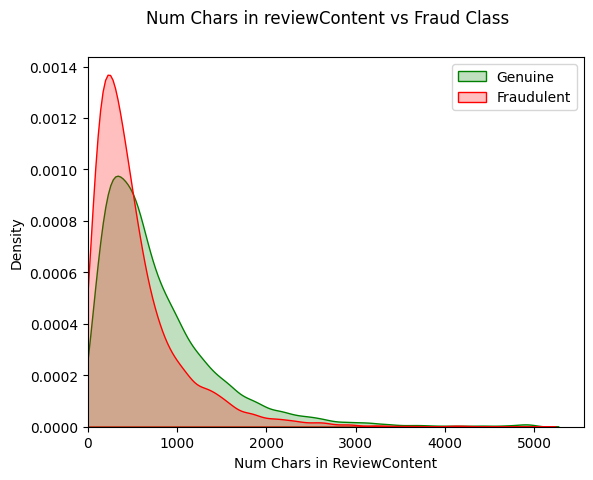

In [129]:
density_plot(num_char_real, num_char_flagged, "Num Chars in ReviewContent", "Density", "Num Chars in reviewContent vs Fraud Class")

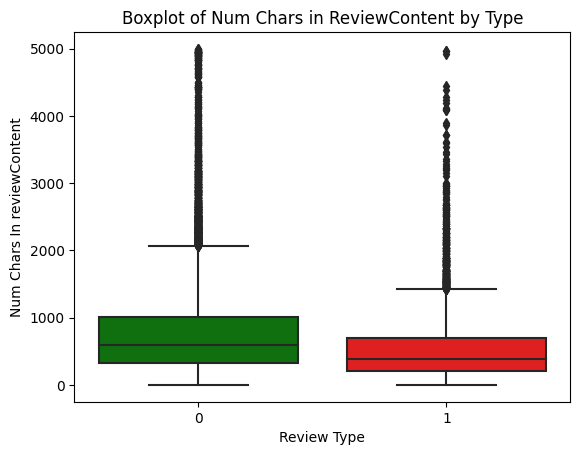

In [130]:
lengths = num_char_real.tolist() + num_char_flagged.tolist()
labels = [0] * len(num_char_real) + [1] * len(num_char_flagged)
num_char_data = pd.DataFrame({
    'Num Chars In ReviewContent': lengths,
    'Review Type': labels
})

new_boxplot(labels,lengths,num_char_data,"Boxplot of Num Chars in ReviewContent by Type","Num Chars In reviewContent", "Review Type")

In [131]:
real_mean = num_char_real.describe()
flagged_mean = num_char_flagged.describe()

compare = pd.DataFrame({"Genuine": real_mean, "Fradulent": flagged_mean})
compare = compare.round(2)
compare

Genuine  Fradulent
count  20752.00    6204.00
mean     777.34     547.03
std      672.19     526.57
min        1.00       1.00
25%      324.00     210.00
50%      590.00     392.00
75%     1018.00     695.00
max     4996.00    4965.00

### Visualisations on the length of words in the review texts

In [132]:
num_words_per_review = df["reviewContent"].apply(lambda x: len(x.split()))
num_words_per_review.describe()

count    26956.000000
mean       133.409964
std        119.199309
min          1.000000
25%         53.000000
50%        100.000000
75%        176.000000
max        971.000000
Name: reviewContent, dtype: float64

In [133]:
reviewFeatures["Num_Words"] = num_words_per_review

In [134]:
length_text_real = df[df["flagged"]==0]["reviewContent"].apply(lambda x: len(x.split()))
length_text_flagged = df[df["flagged"]==1]["reviewContent"].apply(lambda x: len(x.split()))


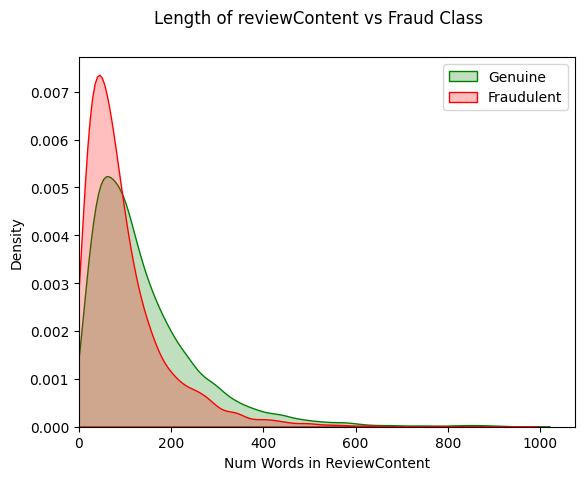

In [135]:
density_plot(length_text_real, length_text_flagged, "Num Words in ReviewContent", "Density","Length of reviewContent vs Fraud Class")

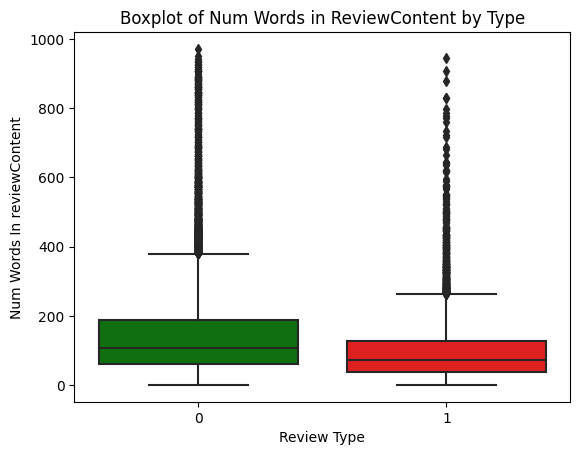

In [136]:
lengths = length_text_real.tolist() + length_text_flagged.tolist()
labels = [0] * len(length_text_real) + [1] * len(length_text_flagged)
num_words_data = pd.DataFrame({
    'Num Words In ReviewContent': lengths,
    'Review Type': labels
})

new_boxplot(labels,lengths,num_words_data,"Boxplot of Num Words in ReviewContent by Type","Num Words In reviewContent", "Review Type")

In [137]:
num_words_data

Num Words In ReviewContent  Review Type
0                             871            0
1                              66            0
2                              45            0
3                             358            0
4                             172            0
...                           ...          ...
26951                          93            1
26952                         117            1
26953                         196            1
26954                          61            1
26955                          32            1

[26956 rows x 2 columns]

In [138]:
real_mean = length_text_real.describe()
flagged_mean = length_text_flagged.describe()

compare = pd.DataFrame({"Genuine": real_mean, "Fradulent": flagged_mean})
compare = compare.round(2)
compare

Genuine  Fradulent
count  20752.00    6204.00
mean     143.16     100.81
std      123.34      97.31
min        1.00       1.00
25%       60.00      38.00
50%      109.00      72.00
75%      188.00     128.00
max      971.00     946.00

##### As seen from the above plots and the statistical comparison between the number of words in the reviewContent differs quite strongly for the 2 classes. Thus, we will be adding this feature as a new column

In [139]:
from collections import Counter
def punctuation_count(text):
    return Counter(char for char in text if char in string.punctuation)
total_punc = df["reviewContent"].apply(punctuation_count)

punctuation_count_real = df[df["flagged"] == 0]["reviewContent"].apply(punctuation_count)
punctuation_count_flagged = df[df["flagged"] == 1]["reviewContent"].apply(punctuation_count)

total_punctuation_real = punctuation_count_real.apply(lambda x: sum(x.values()))
total_punctuation_flagged = punctuation_count_flagged.apply(lambda x: sum(x.values()))
total_punc_count = total_punc.apply(lambda x: sum(x.values()))


In [140]:
reviewFeatures["Total_Punc"] = total_punc_count

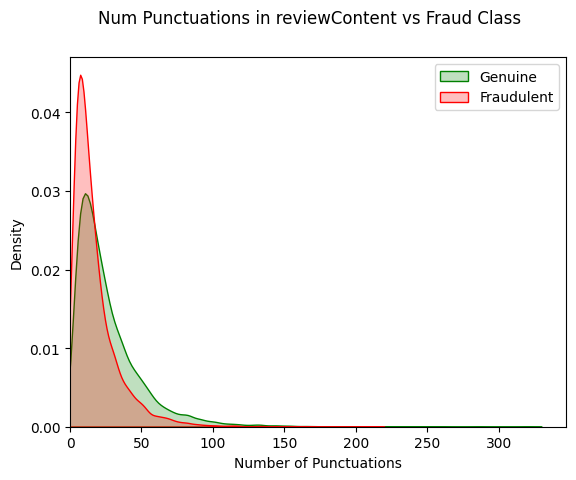

In [141]:
density_plot(total_punctuation_real, total_punctuation_flagged, "Number of Punctuations", "Density","Num Punctuations in reviewContent vs Fraud Class")

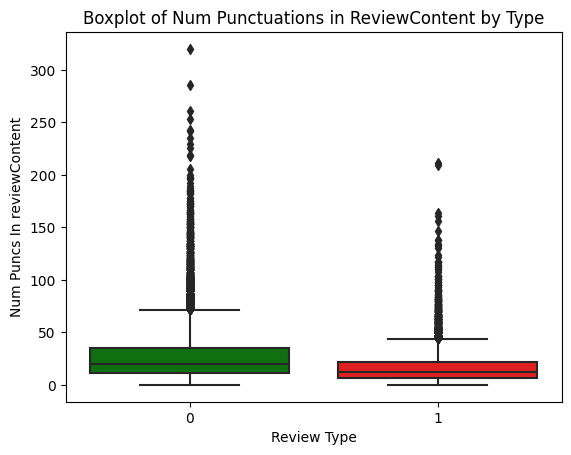

In [142]:
lengths = total_punctuation_real.tolist() + total_punctuation_flagged.tolist()
labels = [0] * len(total_punctuation_real) + [1] * len(total_punctuation_flagged)
num_words_data = pd.DataFrame({
    'Num Punctuations In ReviewContent': lengths,
    'Review Type': labels
})

new_boxplot(labels,lengths,num_words_data,"Boxplot of Num Punctuations in ReviewContent by Type","Num Puncs In reviewContent", "Review Type")

In [143]:
real_mean = total_punctuation_real.describe()
flagged_mean = total_punctuation_flagged.describe()

compare = pd.DataFrame({"Genuine": real_mean, "Fradulent": flagged_mean})
compare = compare.round(2)
compare

Genuine  Fradulent
count  20752.00    6204.00
mean      26.77      17.43
std       24.41      17.20
min        0.00       0.00
25%       11.00       7.00
50%       20.00      12.00
75%       35.00      22.00
max      320.00     211.00

#### Num Capitalized Words

In [144]:
def find_num_capitalized_words(text):
    return sum(1 for word in text.split() if word.isupper())
total_cap = df["reviewContent"].apply(find_num_capitalized_words)
cap_count_real = df[df["flagged"] == 0]["reviewContent"].apply(find_num_capitalized_words)
cap_count_flagged = df[df["flagged"] == 1]["reviewContent"].apply(find_num_capitalized_words)
cap_count_real

0         5
1         0
2         2
3        11
4         4
         ..
26951     3
26952     4
26953     0
26954     0
26955     1
Name: reviewContent, Length: 20752, dtype: int64

In [145]:
reviewFeatures["Num_Cap_Words"] = total_cap

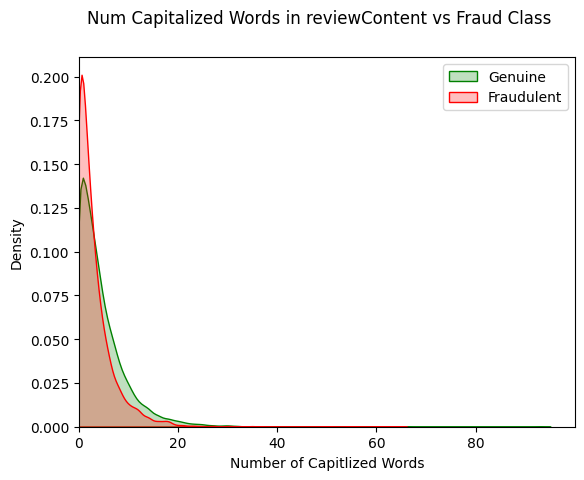

In [146]:
density_plot(cap_count_real, cap_count_flagged, "Number of Capitlized Words", "Density","Num Capitalized Words in reviewContent vs Fraud Class")

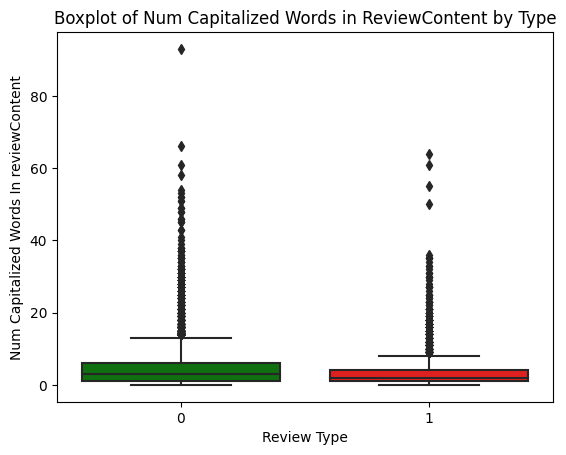

In [147]:
lengths = cap_count_real.tolist() + cap_count_flagged.tolist()
labels = [0] * len(cap_count_real) + [1] * len(cap_count_flagged)
num_words_data = pd.DataFrame({
    'Num Capitalized Words In ReviewContent': lengths,
    'Review Type': labels
})

new_boxplot(labels,lengths,num_words_data,"Boxplot of Num Capitalized Words in ReviewContent by Type","Num Capitalized Words In reviewContent", "Review Type")

In [148]:
real_mean = cap_count_real.describe()
flagged_mean = cap_count_flagged.describe()

compare = pd.DataFrame({"Genuine": real_mean, "Fradulent": flagged_mean})
compare = compare.round(2)
compare

Genuine  Fradulent
count  20752.00    6204.00
mean       4.61       3.16
std        5.13       4.19
min        0.00       0.00
25%        1.00       1.00
50%        3.00       2.00
75%        6.00       4.00
max       93.00      64.00

##### Number of Capitalized Chars

In [149]:
def find_num_capitalized_char(text):
    return sum(1 for word in text if word.isupper())
total_cap_char = df["reviewContent"].apply(find_num_capitalized_char)
cap_char_count_real = df[df["flagged"] == 0]["reviewContent"].apply(find_num_capitalized_char)
cap_char_count_flagged = df[df["flagged"] == 1]["reviewContent"].apply(find_num_capitalized_char)


In [150]:
reviewFeatures["Num_Cap_Char"] = total_cap_char

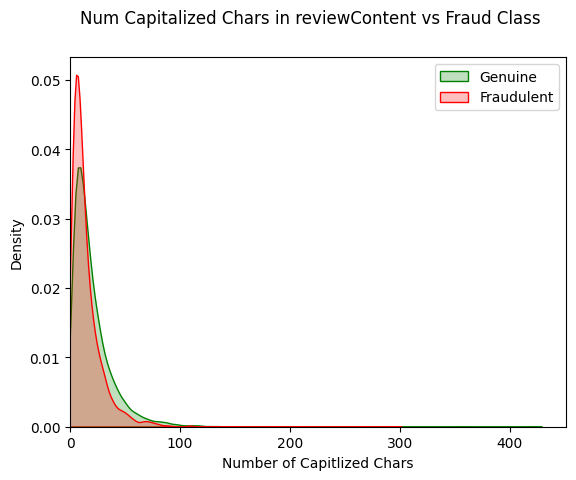

In [151]:
density_plot(cap_char_count_real, cap_char_count_flagged, "Number of Capitlized Chars", "Density","Num Capitalized Chars in reviewContent vs Fraud Class")

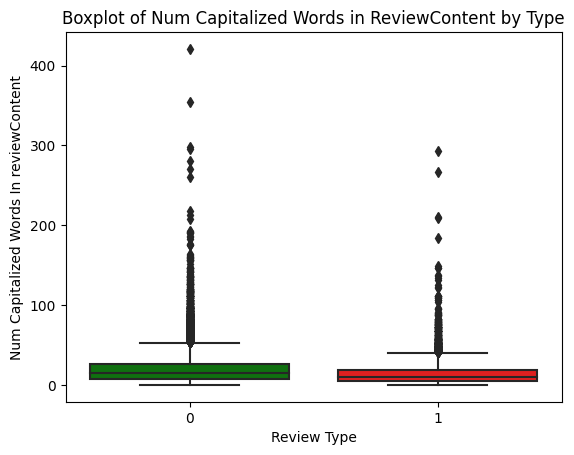

In [152]:
lengths = cap_char_count_real.tolist() + cap_char_count_flagged.tolist()
labels = [0] * len(cap_char_count_real) + [1] * len(cap_char_count_flagged)
num_words_data = pd.DataFrame({
    'Num Capitalized Words In ReviewContent': lengths,
    'Review Type': labels
})

new_boxplot(labels,lengths,num_words_data,"Boxplot of Num Capitalized Words in ReviewContent by Type","Num Capitalized Words In reviewContent", "Review Type")

In [153]:
reviewFeatures

Num_Chars  Num_Words  Total_Punc  Num_Cap_Words  Num_Cap_Char
0           4890        871         143              5            53
1            350         66          10              0             9
2            257         45           9              2             7
3           2156        358          84             11            73
4            951        172          29              4            11
...          ...        ...         ...            ...           ...
26951        512         96          16              3            12
26952        522        102          17              4            19
26953        209         38           8              0             6
26954        347         63          12              0             6
26955        169         36           6              1             2

[26956 rows x 5 columns]

#### Correlation Matrix between the Features 

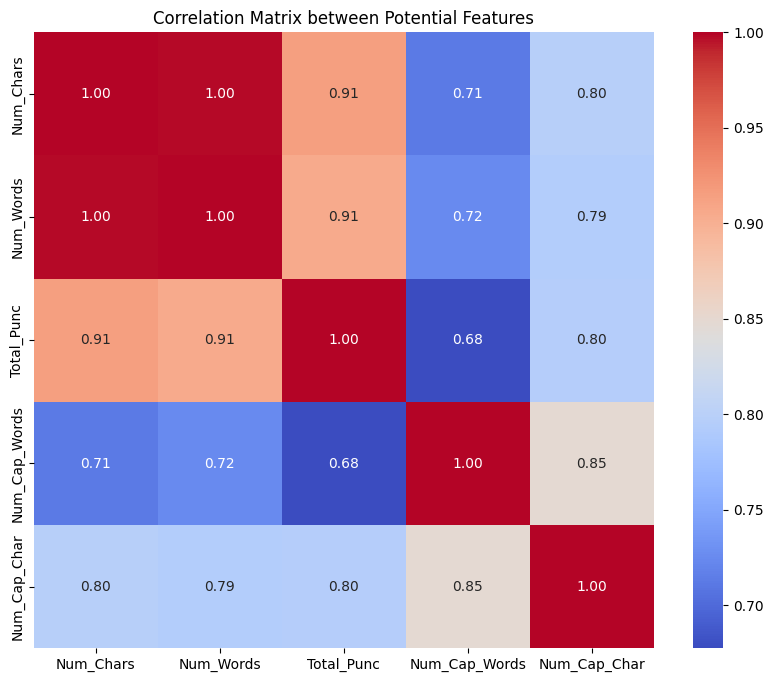

In [154]:
features_matrix = reviewFeatures.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(features_matrix, annot=True, fmt=".2f", cmap='coolwarm', )
plt.title("Correlation Matrix between Potential Features")
plt.show()

In [155]:
reviewFeatures["Y"] = df["flagged"]
reviewFeatures["Y"].value_counts()

Y
0    20752
1     6204
Name: count, dtype: int64

##### From the correlation matrix, we can see that the Num_Chars and Num_Words are perfectly correlated. Total_Punc is also highly correlated with Num_Chars and Num_Words. We shall thus select Total_Puncs given the greater difference in punctuations between the 2 classes based on the earlier visualisations. Besides, Num_Cap_Words and Num_Cap_Char have an evidently and logically high correlation with each other. Given Num_Cap_Words lower correlation with Total_Punc, we decide to keep Num_Cap_Words

#### Feature Importance using Logistic Regression 

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = reviewFeatures.drop('Y', axis=1)
y = reviewFeatures['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [157]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

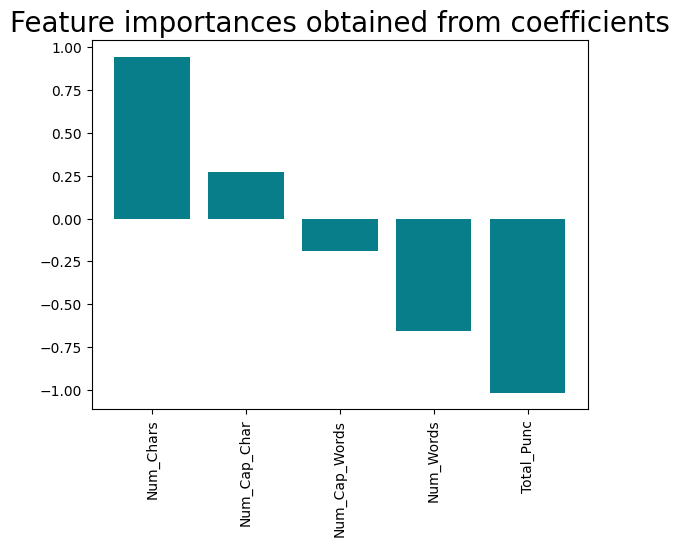

In [158]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### From this feature importance, Total_Punc and Num_Chars seem to be important features as they have highly positive and negative values respectively, indicating that they are strong predictors in this model

In [159]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

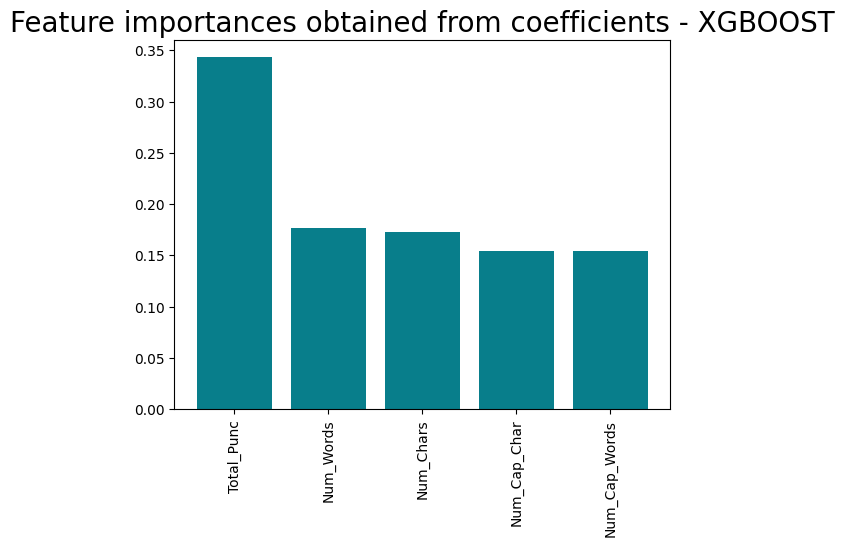

In [160]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients - XGBOOST', size=20)
plt.xticks(rotation='vertical')
plt.show()

#####  Upon the overall analysis, the columns Total punc and Num Chars would be added to the dataframe considering the factors of multicollinearity and feature importance

### POS Tagger

In [161]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [162]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

def count_pos(text):
    words = word_tokenize(text)

    pos_tags = nltk.pos_tag(words)

    tags = [tag for word, tag in pos_tags]

    tag_freq = Counter(tags)

    return pd.Series({
        'noun_count': sum(freq for tag, freq in tag_freq.items() if tag.startswith('NN')),
        'verb_count': sum(freq for tag, freq in tag_freq.items() if tag.startswith('VB')),
        'adj_count': sum(freq for tag, freq in tag_freq.items() if tag.startswith('JJ'))
    })


In [163]:
fraud_df = df[df['flagged'] == 1]
genuine_df = df[df['flagged'] == 0]
fraud_sample = fraud_df.sample(n=100, random_state=1)
genuine_sample = genuine_df.sample(n=100, random_state=1)
sample_df = pd.concat([fraud_sample, genuine_sample])
balanced_sample_df = sample_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [164]:
pos_counts = balanced_sample_df["reviewContent"].apply(count_pos)
balanced_sample_df = pd.concat([balanced_sample_df, pos_counts],axis=1)


In [165]:
balanced_sample_df

reviewDate                reviewID              reviewerID  \
0     7/29/2011  eaOIZI_7_MIscsDtIV85fg  f3U7oi4gLKrYiZCLneYYUw   
1     3/10/2009  IOXWfrCbmgH_8JFI5rmIlA  fgsP9uvZa0tK0jz2JGY1aQ   
2    10/17/2010  angg6YMg4Z4JdN0F5EOn5A  5t3XTDbZAUSElqn7-eNXEg   
3     7/29/2010  3kOrKh6l4Itgzwhx3oM5NQ  vnatfj35e3BvJJz8XL6dzg   
4     9/21/2010  aI39UtF2Wi2zhcq4hmHVig  KlG0SbFFnGkQpCx3kozgPw   
..          ...                     ...                     ...   
195  10/13/2008  PKxEXcWkWHorW63tRyO-7Q  BYs8IIVtYT4aQ32qXf_Zrg   
196   6/25/2010           3ZAxdHwg5qond  hlFD_c_AyPTVsdqZrqrCyQ   
197    6/8/2011  nvaLESe09mNy5sOCWPXVHA  M6EZly--b7gHzwIcWzC0Uw   
198   4/15/2010               M1Qp0YEAO  z7PyvXCkkT6uz2zoo3Hv2A   
199    6/7/2012  EyX5z6S4Iq0NO0v-Gn5p1g  UzDQJhpAwNKgGyPaaV8MBg   

                                         reviewContent  reviewRating  \
0    I have been to this restaurant several times a...             3   
1    Went for lunch during the week. The lunch menu...             3   
2    My husband and I went to Lockdown on a Sunday ...             5   
3    Met up with a few friends for a Saturday brunc...             4   
4    A date suggested this place and I was absolute...             5   
..                                                 ...           ...   
195  I love breakfast and this was definitely a goo...             4   
196  I once went here twice in one weekend (for din...             5   
197  For pictures and more information, please to g...             4   
198  YUM YUM YUM After giving up cheese for Lent, p...             5   
199  Great place for food and drinks. I don't know ...             4   

     reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                    0                0                 0   
1                    0                0                 0   
2                    0                0                 0   
3                    0                0                 0   
4                    2                0                 0   
..                 ...              ...               ...   
195                  0                0                 0   
196                  0                0                 0   
197                  0                0                 0   
198                  2                2                 1   
199                  0                0                 0   

               restaurantID  flagged  ... char_count  \
0    3Mx2PM7v8qjqhgF3cDXxbQ        1  ...        208   
1    rnjz2KNgsQ2YaC_kjeuuAQ        1  ...        202   
2    oCTlReyKjJxKPFYfCurxxQ        1  ...        602   
3    WaIbupMGDBi5B3SChsUH8A        0  ...        476   
4    WaIbupMGDBi5B3SChsUH8A        0  ...        376   
..                      ...      ...  ...        ...   
195  CwPi6NVuJIZZx4IBcTekFQ        0  ...        356   
196  WaIbupMGDBi5B3SChsUH8A        0  ...        835   
197  z_qEuUuRWIq4O-YufXHf1w        1  ...        750   
198  tW2jfL-qMccAYZSghPBbHA        0  ...        534   
199  oCTlReyKjJxKPFYfCurxxQ        1  ...        220   

                                                tokens  \
0    [I, have, been, to, this, restaurant, several,...   
1    [Went, for, lunch, during, the, week, ., The, ...   
2    [My, husband, and, I, went, to, Lockdown, on, ...   
3    [Met, up, with, a, few, friends, for, a, Satur...   
4    [A, date, suggested, this, place, and, I, was,...   
..                                                 ...   
195  [I, love, breakfast, and, this, was, definitel...   
196  [I, once, went, here, twice, in, one, weekend,...   
197  [For, pictures, and, more, information, ,, ple...   
198  [YUM, YUM, YUM, After, giving, up, cheese, for...   
199  [Great, place, for, food, and, drinks, ., I, d...   

                                          clean_tokens  \
0    [restaurant, several, times, every, time, come...   
1    [went, lunch, week, lunch, menu, offers, reaso...   
2    [husband, went, lockdown, sunday, around, 30, ...   


In [166]:
balanced_sample_df

reviewDate                reviewID              reviewerID  \
0     7/29/2011  eaOIZI_7_MIscsDtIV85fg  f3U7oi4gLKrYiZCLneYYUw   
1     3/10/2009  IOXWfrCbmgH_8JFI5rmIlA  fgsP9uvZa0tK0jz2JGY1aQ   
2    10/17/2010  angg6YMg4Z4JdN0F5EOn5A  5t3XTDbZAUSElqn7-eNXEg   
3     7/29/2010  3kOrKh6l4Itgzwhx3oM5NQ  vnatfj35e3BvJJz8XL6dzg   
4     9/21/2010  aI39UtF2Wi2zhcq4hmHVig  KlG0SbFFnGkQpCx3kozgPw   
..          ...                     ...                     ...   
195  10/13/2008  PKxEXcWkWHorW63tRyO-7Q  BYs8IIVtYT4aQ32qXf_Zrg   
196   6/25/2010           3ZAxdHwg5qond  hlFD_c_AyPTVsdqZrqrCyQ   
197    6/8/2011  nvaLESe09mNy5sOCWPXVHA  M6EZly--b7gHzwIcWzC0Uw   
198   4/15/2010               M1Qp0YEAO  z7PyvXCkkT6uz2zoo3Hv2A   
199    6/7/2012  EyX5z6S4Iq0NO0v-Gn5p1g  UzDQJhpAwNKgGyPaaV8MBg   

                                         reviewContent  reviewRating  \
0    I have been to this restaurant several times a...             3   
1    Went for lunch during the week. The lunch menu...             3   
2    My husband and I went to Lockdown on a Sunday ...             5   
3    Met up with a few friends for a Saturday brunc...             4   
4    A date suggested this place and I was absolute...             5   
..                                                 ...           ...   
195  I love breakfast and this was definitely a goo...             4   
196  I once went here twice in one weekend (for din...             5   
197  For pictures and more information, please to g...             4   
198  YUM YUM YUM After giving up cheese for Lent, p...             5   
199  Great place for food and drinks. I don't know ...             4   

     reviewUsefulCount  reviewCoolCount  reviewFunnyCount  \
0                    0                0                 0   
1                    0                0                 0   
2                    0                0                 0   
3                    0                0                 0   
4                    2                0                 0   
..                 ...              ...               ...   
195                  0                0                 0   
196                  0                0                 0   
197                  0                0                 0   
198                  2                2                 1   
199                  0                0                 0   

               restaurantID  flagged  ... char_count  \
0    3Mx2PM7v8qjqhgF3cDXxbQ        1  ...        208   
1    rnjz2KNgsQ2YaC_kjeuuAQ        1  ...        202   
2    oCTlReyKjJxKPFYfCurxxQ        1  ...        602   
3    WaIbupMGDBi5B3SChsUH8A        0  ...        476   
4    WaIbupMGDBi5B3SChsUH8A        0  ...        376   
..                      ...      ...  ...        ...   
195  CwPi6NVuJIZZx4IBcTekFQ        0  ...        356   
196  WaIbupMGDBi5B3SChsUH8A        0  ...        835   
197  z_qEuUuRWIq4O-YufXHf1w        1  ...        750   
198  tW2jfL-qMccAYZSghPBbHA        0  ...        534   
199  oCTlReyKjJxKPFYfCurxxQ        1  ...        220   

                                                tokens  \
0    [I, have, been, to, this, restaurant, several,...   
1    [Went, for, lunch, during, the, week, ., The, ...   
2    [My, husband, and, I, went, to, Lockdown, on, ...   
3    [Met, up, with, a, few, friends, for, a, Satur...   
4    [A, date, suggested, this, place, and, I, was,...   
..                                                 ...   
195  [I, love, breakfast, and, this, was, definitel...   
196  [I, once, went, here, twice, in, one, weekend,...   
197  [For, pictures, and, more, information, ,, ple...   
198  [YUM, YUM, YUM, After, giving, up, cheese, for...   
199  [Great, place, for, food, and, drinks, ., I, d...   

                                          clean_tokens  \
0    [restaurant, several, times, every, time, come...   
1    [went, lunch, week, lunch, menu, offers, reaso...   
2    [husband, went, lockdown, sunday, around, 30, ...   


#### Noun Counts 

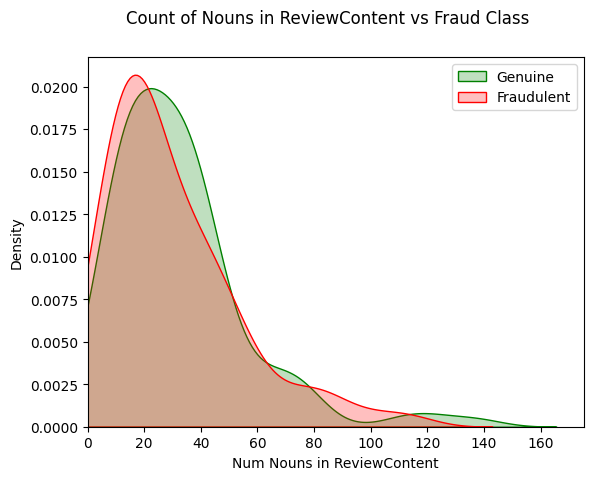

In [167]:
fraud_rows = balanced_sample_df[balanced_sample_df["flagged"]== 1]
gen_rows = balanced_sample_df[balanced_sample_df["flagged"]== 0]
fraud_noun = fraud_rows["noun_count"]
gen_noun = gen_rows["noun_count"]
density_plot(gen_noun, fraud_noun, "Num Nouns in ReviewContent", "Density","Count of Nouns in ReviewContent vs Fraud Class")

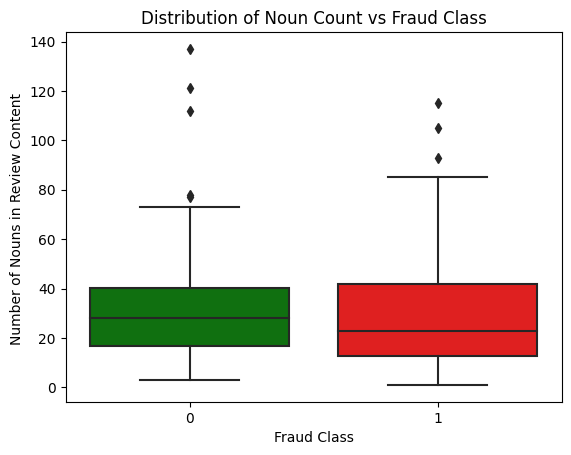

In [168]:
fig, ax = plt.subplots()

sns.boxplot(x="flagged", y="noun_count", data=balanced_sample_df, palette={1: "red", 0: "green"}, ax=ax)

ax.set_title("Distribution of Noun Count vs Fraud Class")
ax.set_ylabel("Number of Nouns in Review Content ")
ax.set_xlabel("Fraud Class")

plt.show()

#### Verb Count 

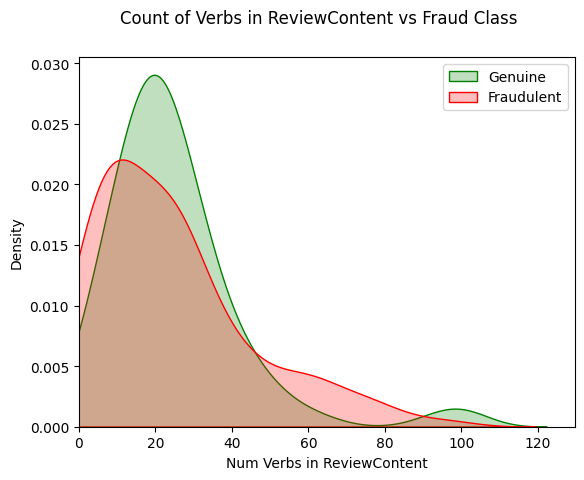

In [169]:
fraud_rows = balanced_sample_df[balanced_sample_df["flagged"]== 1]
gen_rows = balanced_sample_df[balanced_sample_df["flagged"]== 0]
fraud_verb = fraud_rows["verb_count"]
gen_verb = gen_rows["verb_count"]
density_plot(gen_verb, fraud_verb, "Num Verbs in ReviewContent", "Density","Count of Verbs in ReviewContent vs Fraud Class")
# density_plot(gen_noun, fraud_noun, "NounCount for Review Content," "Density", "Noun Count VS Fraud Class")


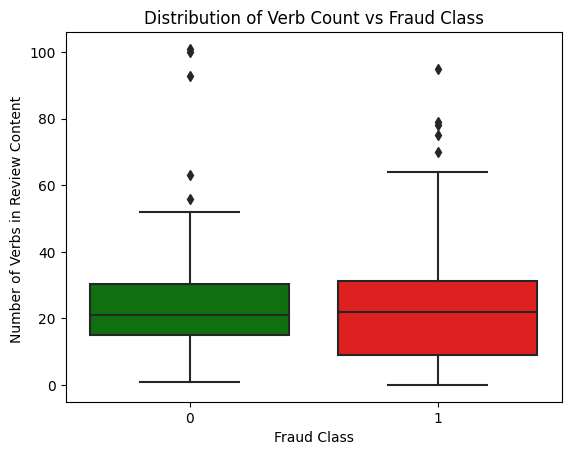

In [170]:
fig, ax = plt.subplots()

# Plot the boxplot on the axis object
sns.boxplot(x="flagged", y="verb_count", data=balanced_sample_df, palette={1: "red", 0: "green"}, ax=ax)

# Set the title and axis labels
ax.set_title("Distribution of Verb Count vs Fraud Class")
ax.set_ylabel("Number of Verbs in Review Content ")
ax.set_xlabel("Fraud Class")

# Display the plot
plt.show()

#### Adj Count

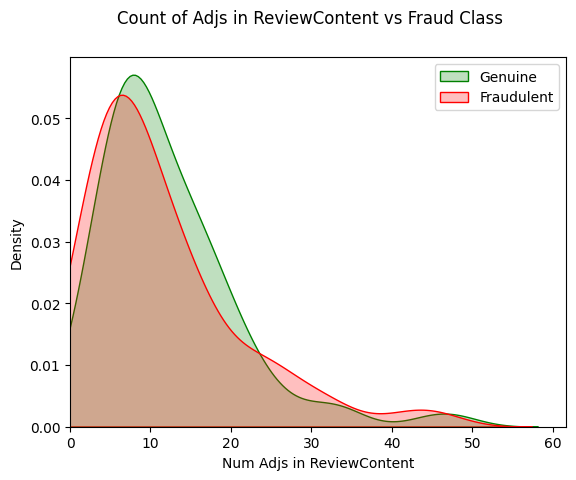

In [171]:
fraud_rows = balanced_sample_df[balanced_sample_df["flagged"]== 1]
gen_rows = balanced_sample_df[balanced_sample_df["flagged"]== 0]
fraud_adj = fraud_rows["adj_count"]
gen_adj = gen_rows["adj_count"]
density_plot(gen_adj, fraud_adj, "Num Adjs in ReviewContent", "Density","Count of Adjs in ReviewContent vs Fraud Class")
# density_plot(gen_noun, fraud_noun, "NounCount for Review Content," "Density", "Noun Count VS Fraud Class")


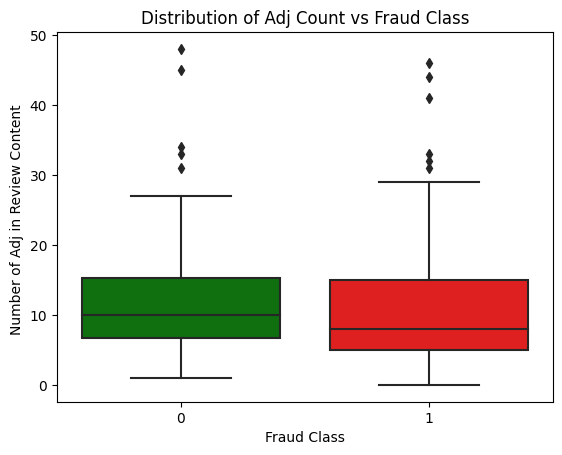

In [172]:
fig, ax = plt.subplots()

# Plot the boxplot on the axis object
sns.boxplot(x="flagged", y="adj_count", data=balanced_sample_df, palette={1: "red", 0: "green"}, ax=ax)

# Set the title and axis labels
ax.set_title("Distribution of Adj Count vs Fraud Class")
ax.set_ylabel("Number of Adj in Review Content ")
ax.set_xlabel("Fraud Class")

# Display the plot
plt.show()

### Correlation Matrix between the Noun, Verb and Adj Counts 

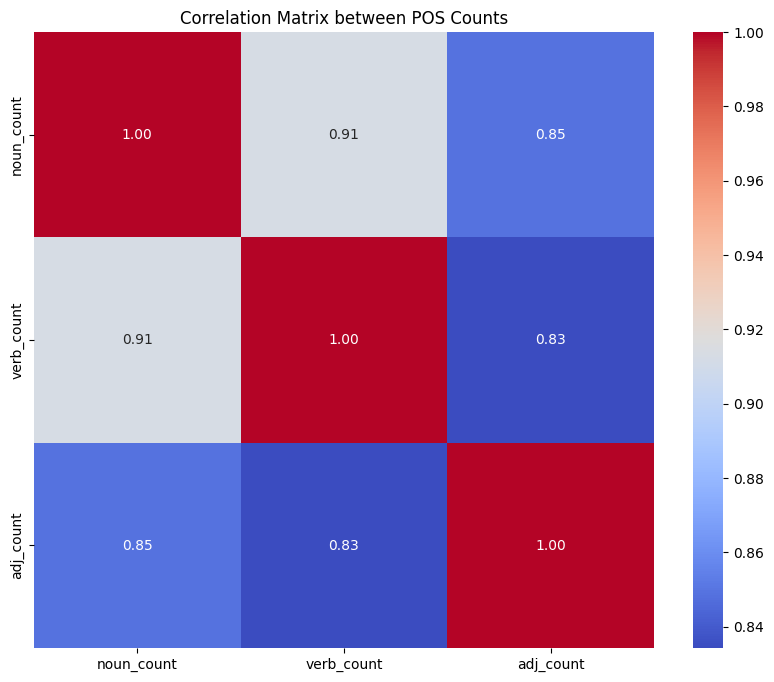

In [173]:
counts = balanced_sample_df[["noun_count", "verb_count", "adj_count", "flagged"]]

pos_matrix = counts.drop(columns=["flagged"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pos_matrix, annot=True, fmt=".2f", cmap='coolwarm', )
plt.title("Correlation Matrix between POS Counts")
plt.show()

In [174]:
balanced_sample_df.columns

Index(['reviewDate', 'reviewID', 'reviewerID', 'reviewContent', 'reviewRating',
       'reviewUsefulCount', 'reviewCoolCount', 'reviewFunnyCount',
       'restaurantID', 'flagged', 'reviewerName', 'reviewerLocation',
       'reviewerYelpJoinDate', 'reviewerFriendCount', 'reviewerNumReviews',
       'reviewerFirstCount', 'reviewerUsefulCount', 'reviewerCoolCount',
       'reviewerFunnyCount', 'reviewerComplimentCount', 'reviewerTipCount',
       'reviewerFanCount', 'resLocation', 'resName', 'resReviewCount',
       'resRating', 'DATE_TIME', 'EMAIL_ADDRESS', 'NRP', 'LOCATION', 'PERSON',
       'PHONE_NUMBER', 'DATE_TIME_count', 'EMAIL_ADDRESS_count', 'NRP_count',
       'LOCATION_count', 'PERSON_count', 'PHONE_NUMBER_count',
       'DATE_TIME_flag', 'EMAIL_ADDRESS_flag', 'NRP_flag', 'LOCATION_flag',
       'PERSON_flag', 'PHONE_NUMBER_flag', 'reviewDate2',
       'date_diff_joinedandreviewed', 'word_count', 'char_count', 'tokens',
       'clean_tokens', 'clean_text', 'ngrams', 'preproces

In [175]:
feature_dataset = balanced_sample_df.drop(columns=["reviewDate", "reviewID", "reviewerID", "reviewContent", "restaurantID", "reviewerName", "resName", "reviewerLocation", "resLocation"\
    , "reviewerYelpJoinDate", 'NRP', 'LOCATION', 'PERSON',
       'PHONE_NUMBER', 'DATE_TIME_count', 'EMAIL_ADDRESS_count', 'NRP_count',
       'LOCATION_count', 'PERSON_count', 'PHONE_NUMBER_count',
       'DATE_TIME_flag', 'EMAIL_ADDRESS_flag', 'NRP_flag', 'LOCATION_flag',
       'PERSON_flag', 'PHONE_NUMBER_flag', 'reviewDate2',
        'DATE_TIME', 'EMAIL_ADDRESS','clean_tokens', 'clean_text', 'ngrams', 'preprocessed', 'tokens' ])
feature_dataset.columns


Index(['reviewRating', 'reviewUsefulCount', 'reviewCoolCount',
       'reviewFunnyCount', 'flagged', 'reviewerFriendCount',
       'reviewerNumReviews', 'reviewerFirstCount', 'reviewerUsefulCount',
       'reviewerCoolCount', 'reviewerFunnyCount', 'reviewerComplimentCount',
       'reviewerTipCount', 'reviewerFanCount', 'resReviewCount', 'resRating',
       'date_diff_joinedandreviewed', 'word_count', 'char_count', 'main_topic',
       'noun_count', 'verb_count', 'adj_count'],
      dtype='object')

#### Feature Importance on Balanced Dataset 

In [176]:
X = feature_dataset.drop('flagged', axis=1)
y = feature_dataset['flagged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [177]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

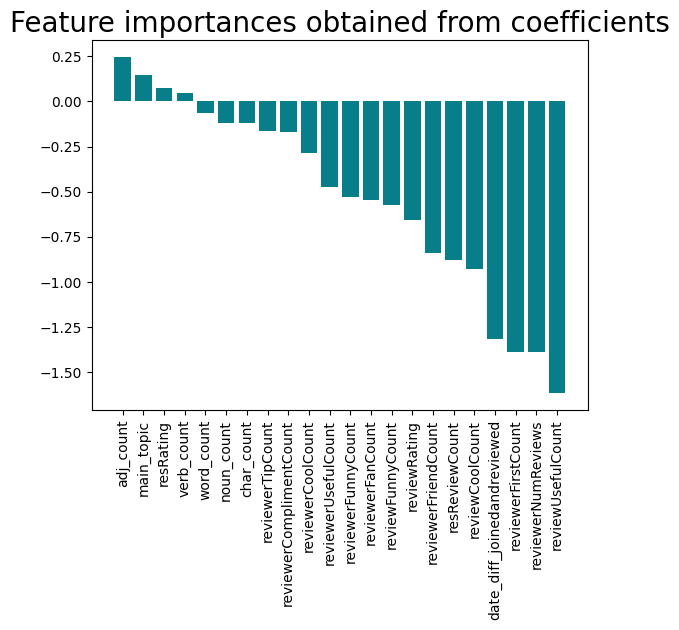

In [178]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### From the above analysis, together with the density / boxplots of how noun, adj and verb count segregates between the 2 classes, verb_count would be added to the dataframe 

In [179]:

model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)


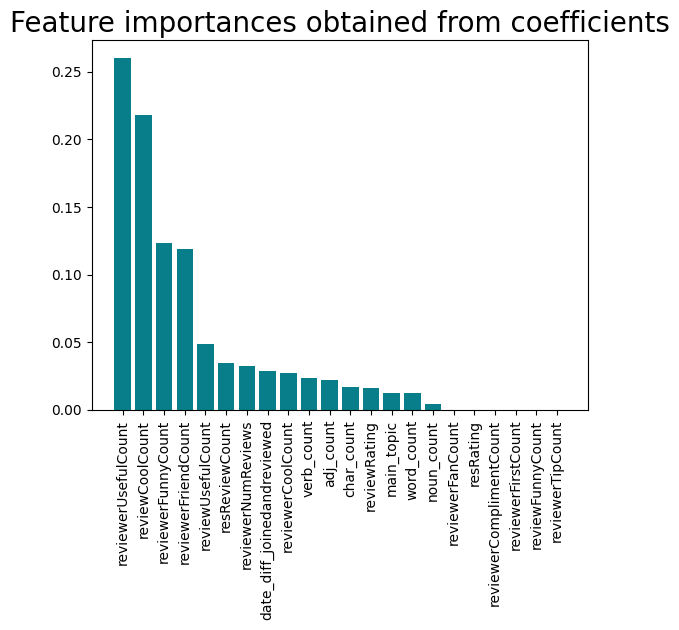

In [180]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Take verb_count and adj_count based on factors on lower correlation and higher feature importance 

In [181]:
balanced_sample_df.columns

Index(['reviewDate', 'reviewID', 'reviewerID', 'reviewContent', 'reviewRating',
       'reviewUsefulCount', 'reviewCoolCount', 'reviewFunnyCount',
       'restaurantID', 'flagged', 'reviewerName', 'reviewerLocation',
       'reviewerYelpJoinDate', 'reviewerFriendCount', 'reviewerNumReviews',
       'reviewerFirstCount', 'reviewerUsefulCount', 'reviewerCoolCount',
       'reviewerFunnyCount', 'reviewerComplimentCount', 'reviewerTipCount',
       'reviewerFanCount', 'resLocation', 'resName', 'resReviewCount',
       'resRating', 'DATE_TIME', 'EMAIL_ADDRESS', 'NRP', 'LOCATION', 'PERSON',
       'PHONE_NUMBER', 'DATE_TIME_count', 'EMAIL_ADDRESS_count', 'NRP_count',
       'LOCATION_count', 'PERSON_count', 'PHONE_NUMBER_count',
       'DATE_TIME_flag', 'EMAIL_ADDRESS_flag', 'NRP_flag', 'LOCATION_flag',
       'PERSON_flag', 'PHONE_NUMBER_flag', 'reviewDate2',
       'date_diff_joinedandreviewed', 'word_count', 'char_count', 'tokens',
       'clean_tokens', 'clean_text', 'ngrams', 'preproces

#### Review Counts 

In [182]:
compare = pd.DataFrame({
    "Fake": df[df["flagged"]==1]["reviewUsefulCount"].describe(),
    "Genuine": df[df["flagged"]==0]["reviewUsefulCount"].describe()
})
compare

Fake       Genuine
count  6204.0  20752.000000
mean      0.0      0.945692
std       0.0      2.063376
min       0.0      0.000000
25%       0.0      0.000000
50%       0.0      0.000000
75%       0.0      1.000000
max       0.0     49.000000